# Housekeeping

In [2]:
sessionInfo()
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)
update.packages()

R version 4.0.3 Patched (2020-10-12 r79333)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.3  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.3     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.8    
[17] evaluate_0.14  

# Nearest Neighbors for Forensic Glass

Load a package that already has the example data set up.

In [3]:
library(MASS)
data(fgl)

Some Jupyter notebook housekeeping for better graphics.

In [4]:
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)

Make six plots, which by default will be box plots of the continuous outcome broken down by the factors of the right-hand-side variable.

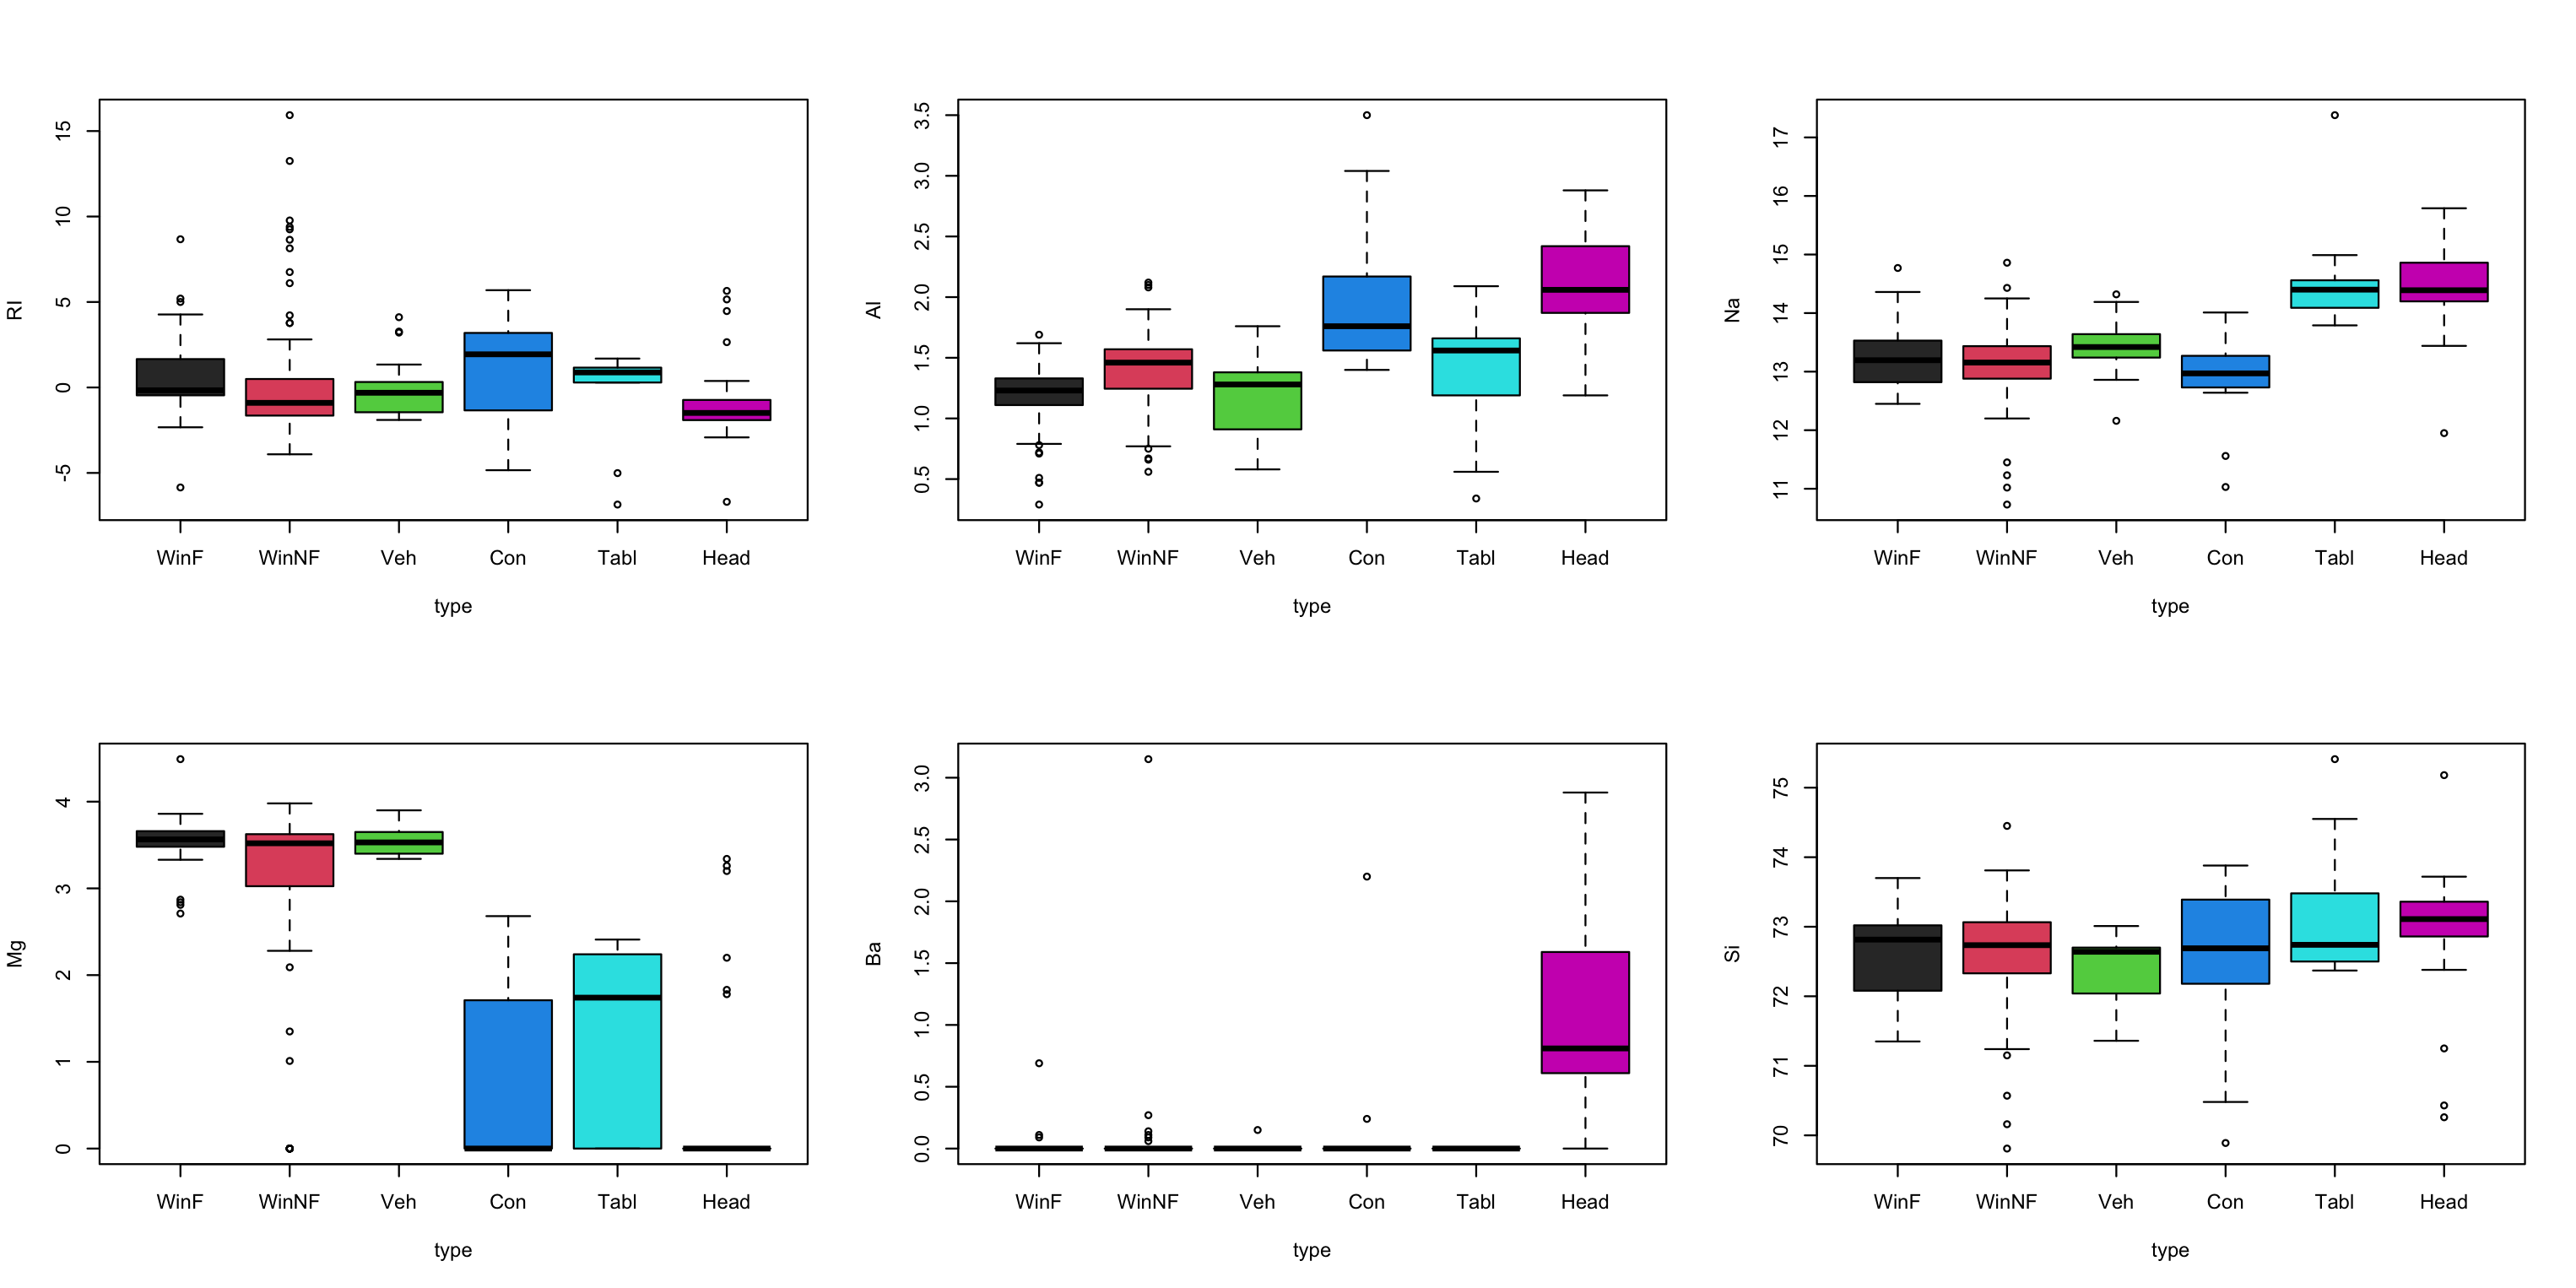

In [5]:
par(mfrow=c(2,3))
plot(RI ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Al ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Na ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Mg ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Ba ~ type, data=fgl, col=c(grey(.2),2:6))
plot(Si ~ type, data=fgl, col=c(grey(.2),2:6))

Make the first nine variables numeric and standardize them (subtract the mean and divide by the standard deviation). By a clever use of the `apply` function we can call `sd` on each column (dimension `2`) of `x`, calculating the standard deviation. It should be 1 by now.

In [6]:
x <- scale(fgl[,1:9])
apply(x,2,sd)

RI Na Mg Al Si  K Ca Ba Fe 
 1  1  1  1  1  1  1  1  1

Using the standard `class` package, do nearest-neighbor matching for 14 test observations using 200 training points. Note that are picking the test cases at random here, so we won't replicate the results in the book. 

In [7]:
library(class)
test <- sample(1:214,14)
nearest1 <- knn(train=x[-test,], test=x[test,], cl=fgl$type[-test], k=1)
nearest5 <- knn(train=x[-test,], test=x[test,], cl=fgl$type[-test], k=5)
data.frame(fgl$type[test],nearest1,nearest5)

fgl.type.test.,nearest1,nearest5
<fct>,<fct>,<fct>
WinF,WinF,WinF
Veh,Veh,WinNF
WinF,WinNF,WinNF
WinF,WinF,WinF
WinNF,Veh,WinF
WinNF,WinNF,WinF
WinF,WinNF,WinNF
WinNF,WinNF,WinNF
WinNF,WinNF,WinNF


# Credit

We have some data from a German lender.

In [8]:
credit <- read.csv("credit.csv")

We can factor and label the levels of credit history.

In [9]:
credit$history = factor(credit$history, levels=c("A30","A31","A32","A33","A34"))
levels(credit$history) = c("good","good","poor","poor","terrible")

Similarly for variables denoting nationality, renter status, and purpose for the loan.

In [10]:
credit$foreign <- factor(credit$foreign, levels=c("A201","A202"), labels=c("foreign","german"))
credit$rent <- factor(credit$housing=="A151")
credit$purpose <- factor(credit$purpose, levels=c("A40","A41","A42","A43","A44","A45","A46","A47","A48","A49","A410"))
levels(credit$purpose) <- c("newcar","usedcar",rep("goods/repair",4),"edu",NA,"edu","biz","biz")

Pick some variables to keep.

In [11]:
credit <- credit[,c("Default", "duration", "amount",
                    "installment", "age", "history",
                    "purpose", "foreign", "rent")]

Let's plot default rates by categories of history.

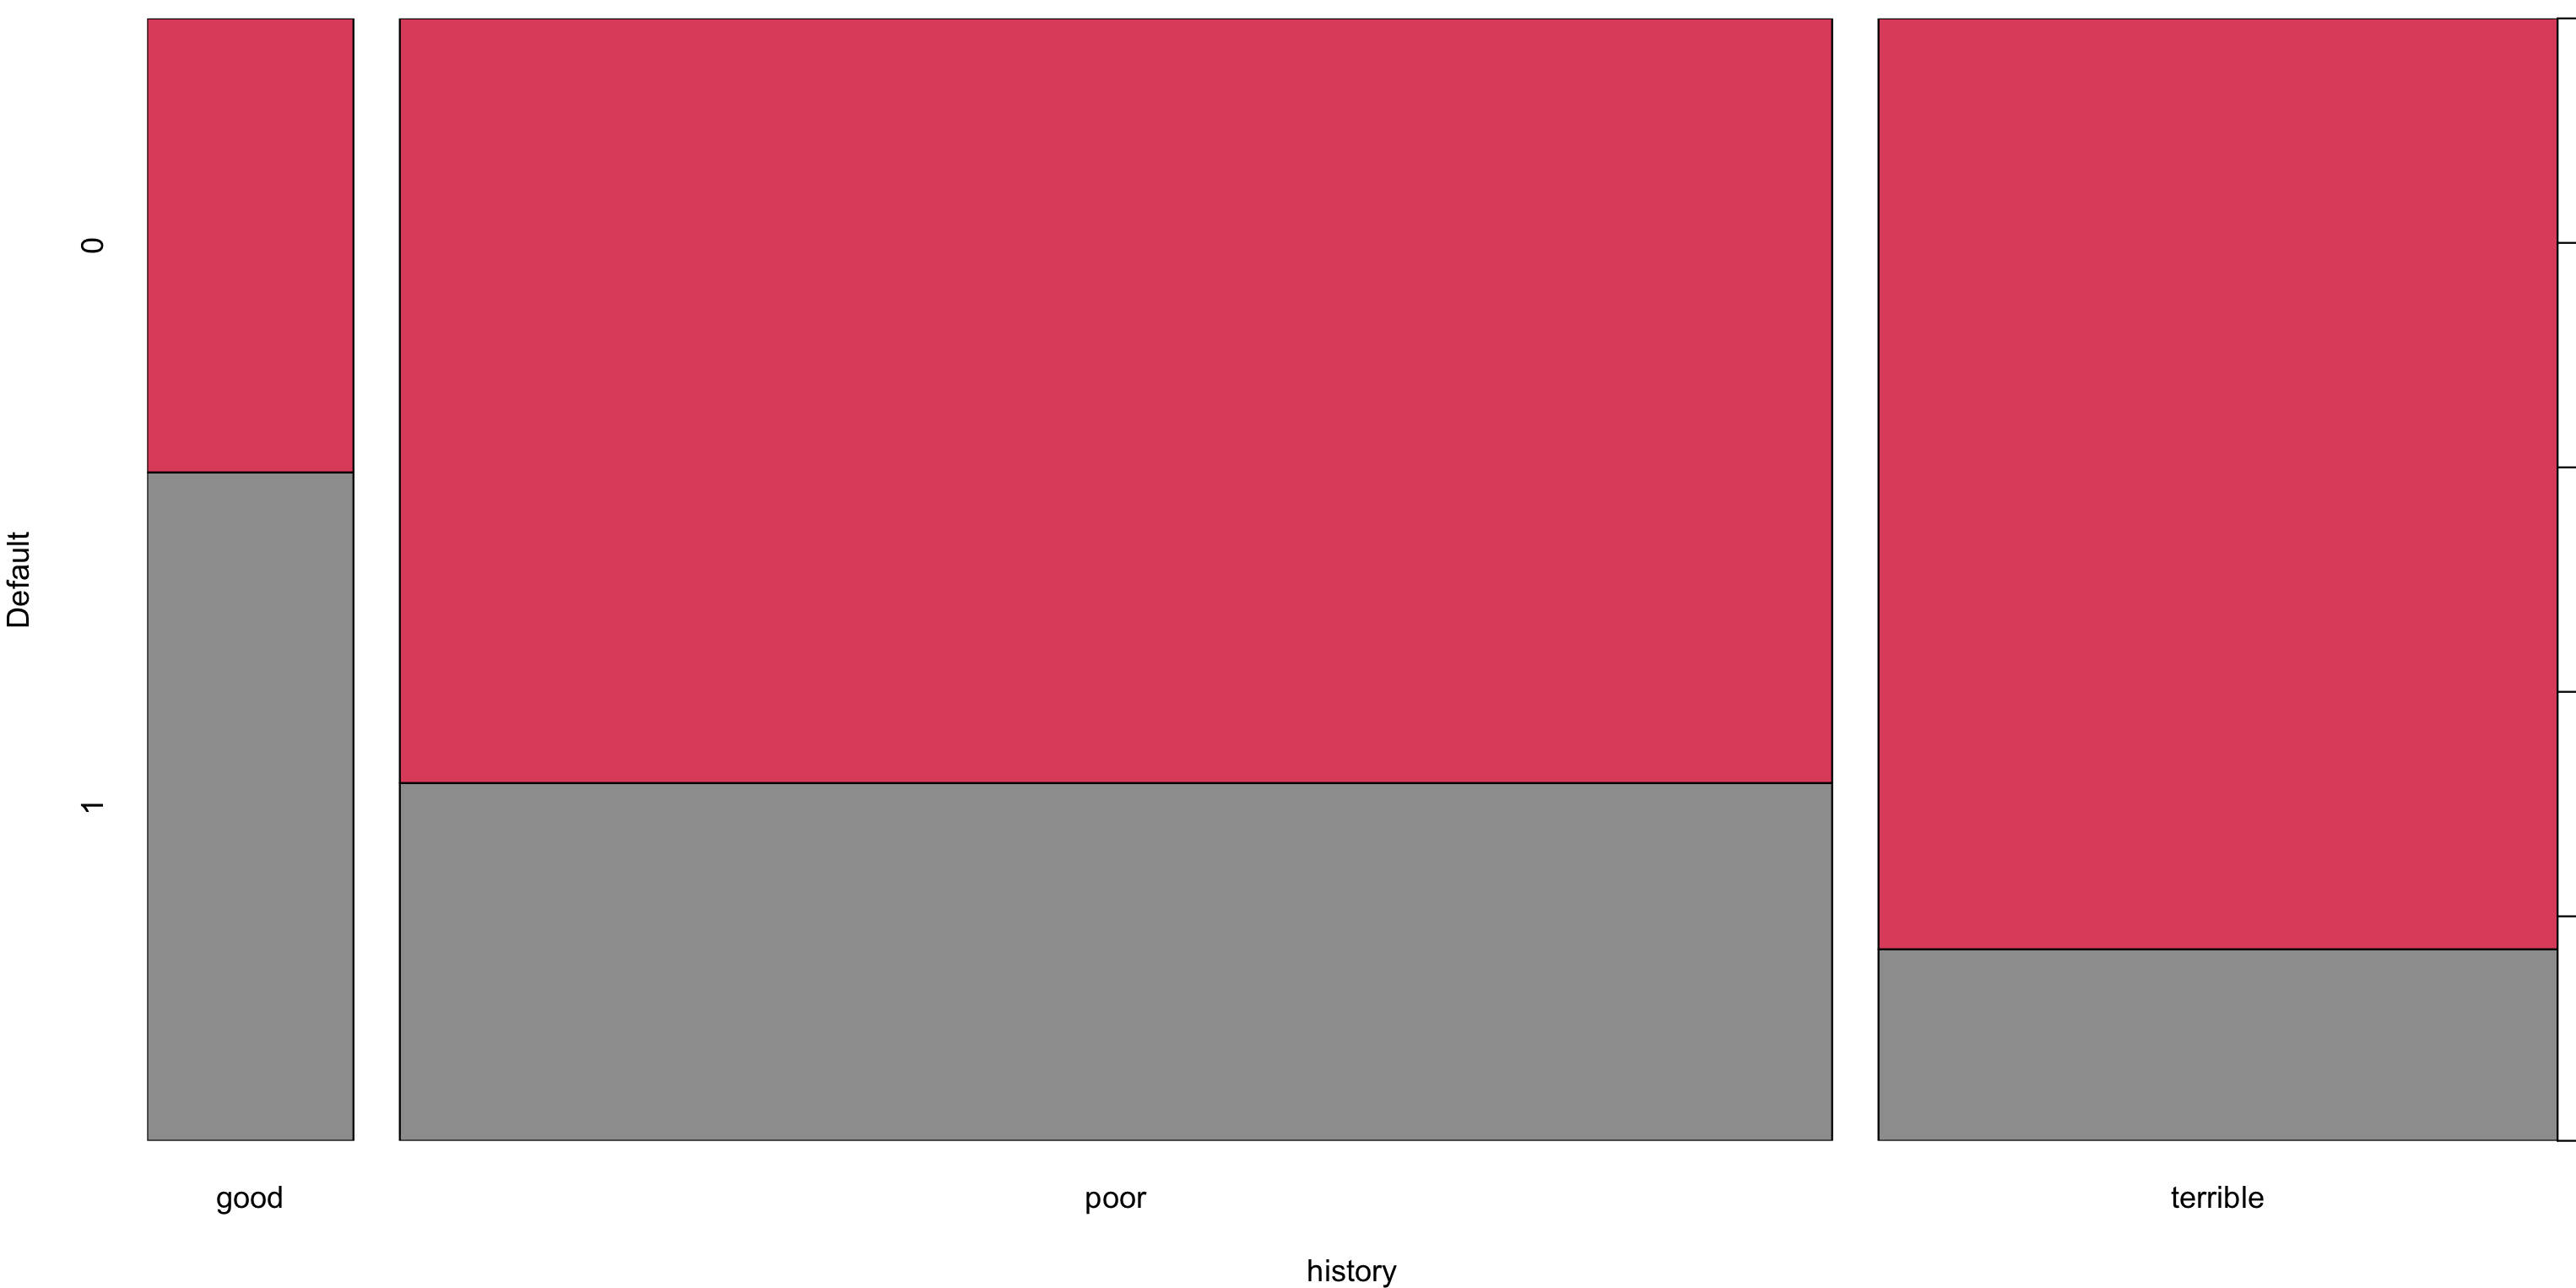

In [12]:
par(mai=c(.8,.8,.1,.1))
plot(factor(Default) ~ history, data=credit, col=c(8,2), ylab="Default")

Convice yourselves why this pattern is surprising, but not really. :)

Then we proceed with a design matrix. Note some tricks: you can interact each variable with each other (and themselves) using a power notation. Also, we want to use the `naref` function from before not to leave out a reference level and have dummies and coefficients for each.

In [13]:
library(gamlr)
source("naref.R")
credx <- sparse.model.matrix( Default ~ .^2, data=naref(credit))[,-1]
default <- credit$Default

Loading required package: Matrix



We are ready for a binomial model, without any classification yet:

In [14]:
credscore <- cv.gamlr(credx, default, family="binomial", verb=TRUE)

fold 1,2,3,4,5,done.


Make the two "standard" plots.

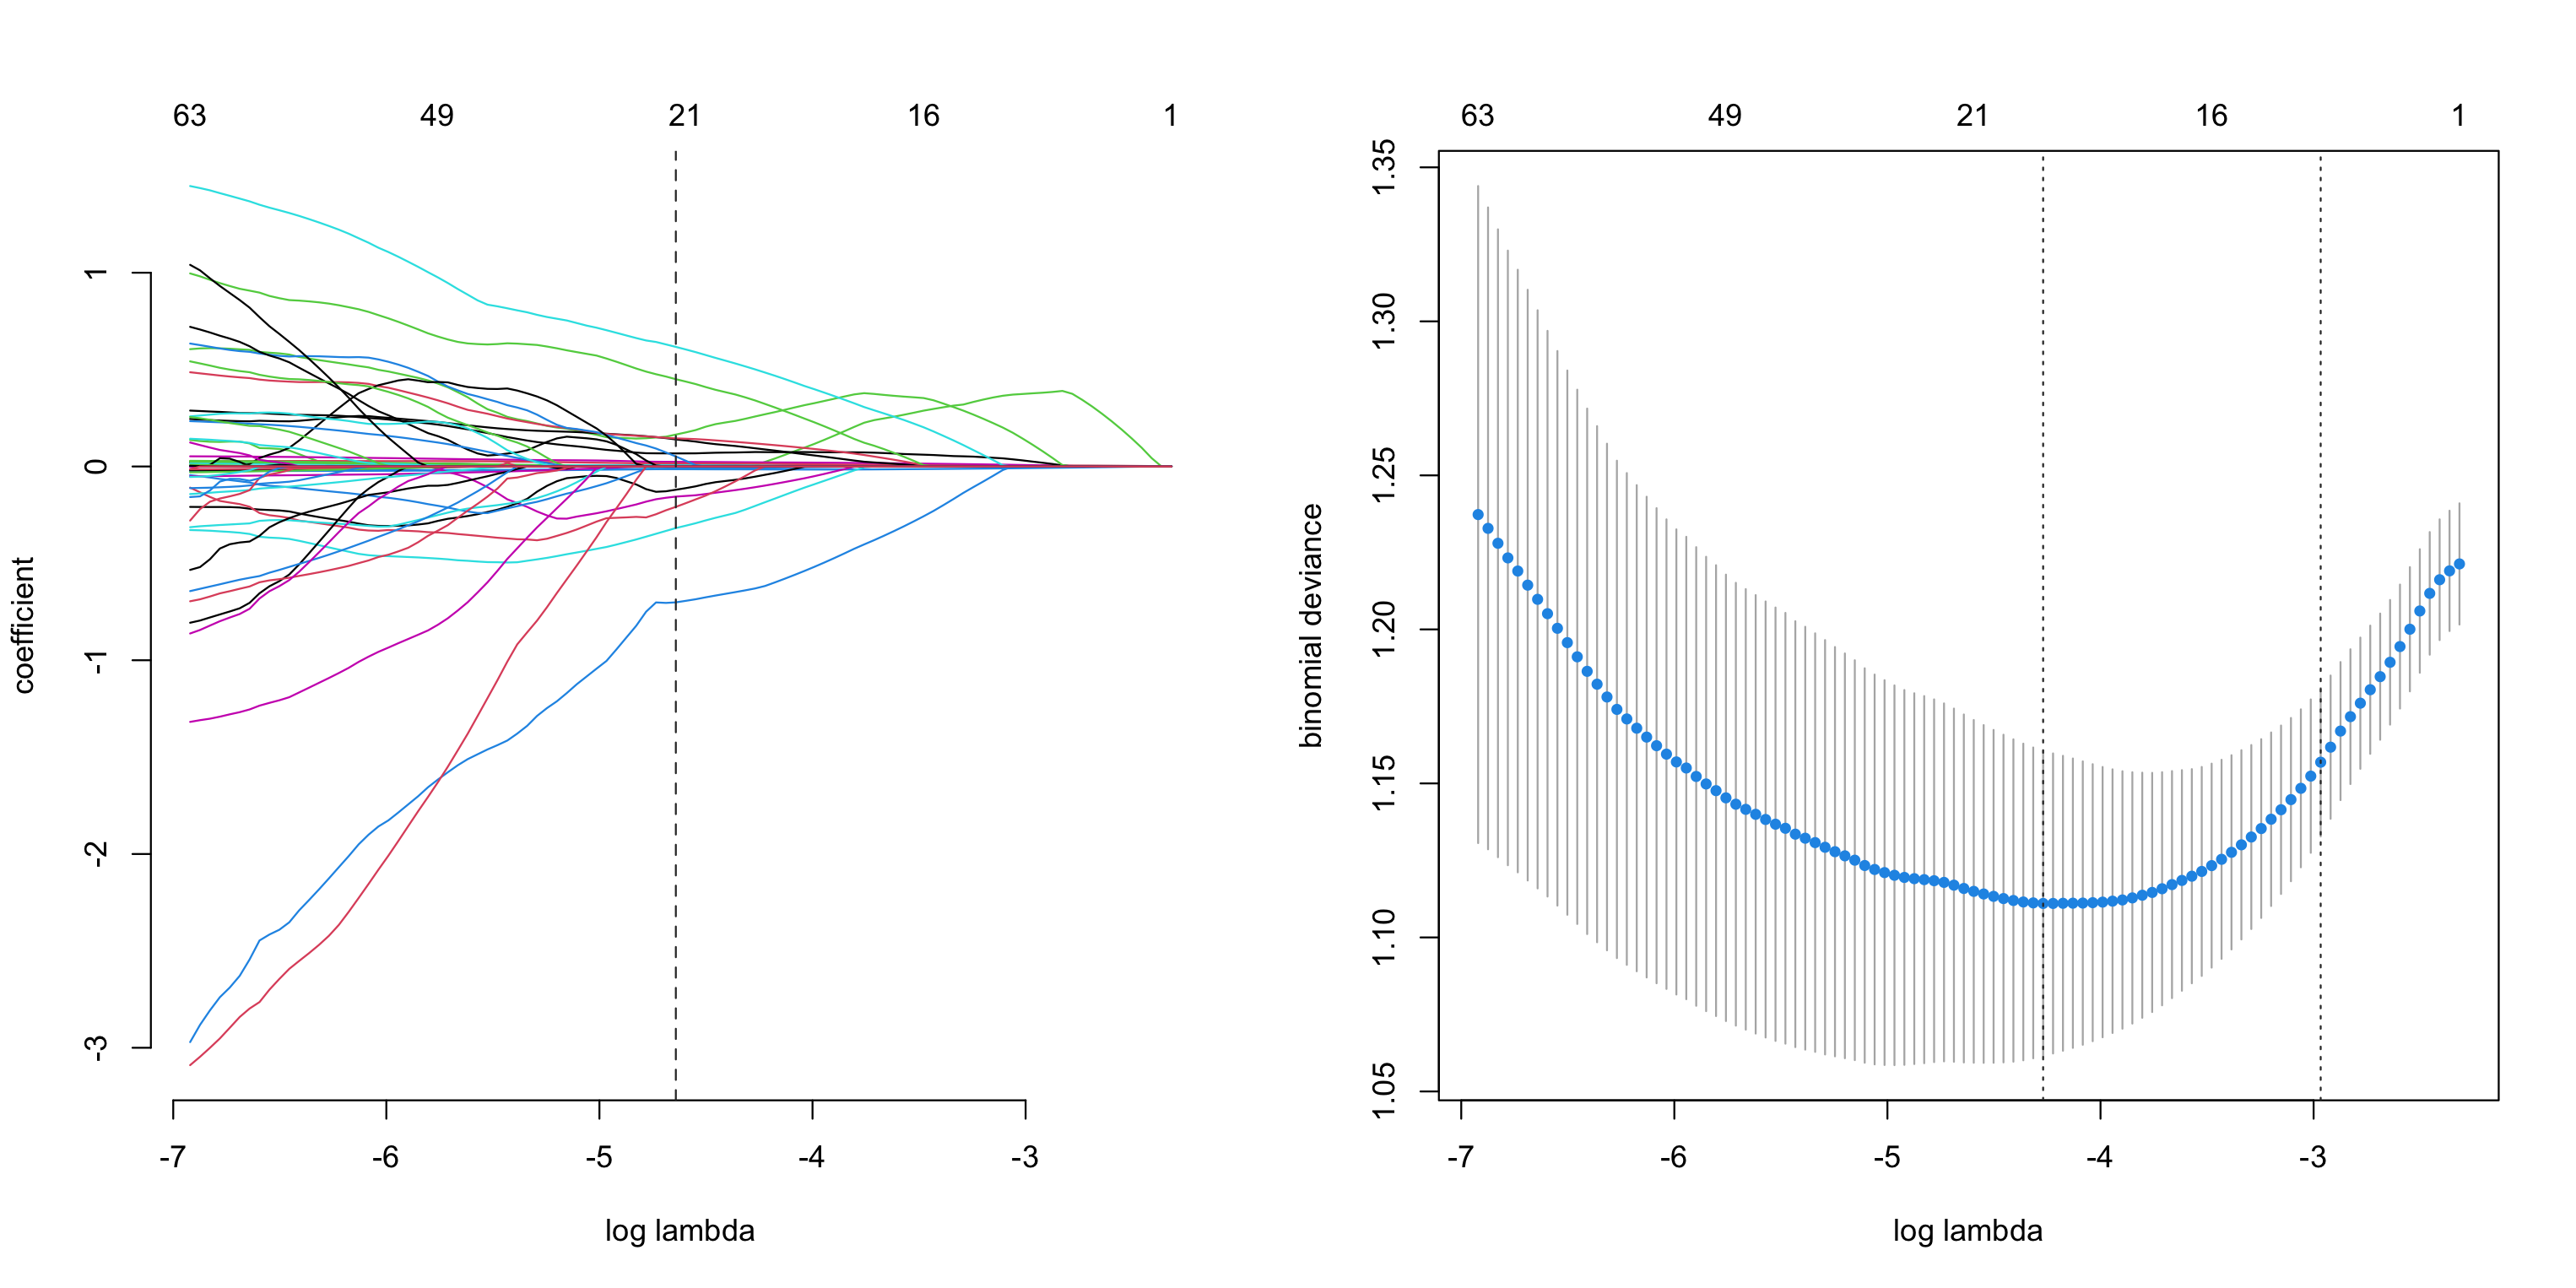

In [15]:
par(mfrow=c(1,2))
plot(credscore$gamlr)
plot(credscore)

How many variables are included in the cross-validated deviance-minimizing model? And the AICc-minimizing one if we saved ourselves the trouble? And using the default 1SE rule? AIC? BIC?

In [16]:
sum(coef(credscore, s="min")!=0) # min
sum(coef(credscore$gamlr)!=0) # AICc

sum(coef(credscore)!=0) # 1se
sum(coef(credscore$gamlr, s=which.min(AIC(credscore$gamlr)))!=0) # AIC
sum(coef(credscore$gamlr, s=which.min(BIC(credscore$gamlr)))!=0) # BIC

[1] 21

[1] 21

[1] 10

[1] 21

[1] 19

Check the out-of-sample R2 (from deviances!)

In [17]:
1 - credscore$cvm[credscore$seg.min]/credscore$cvm[1]

[1] 0.09025473

Generate in-sample probability estimates (and also drop the sparse matrix formatting)

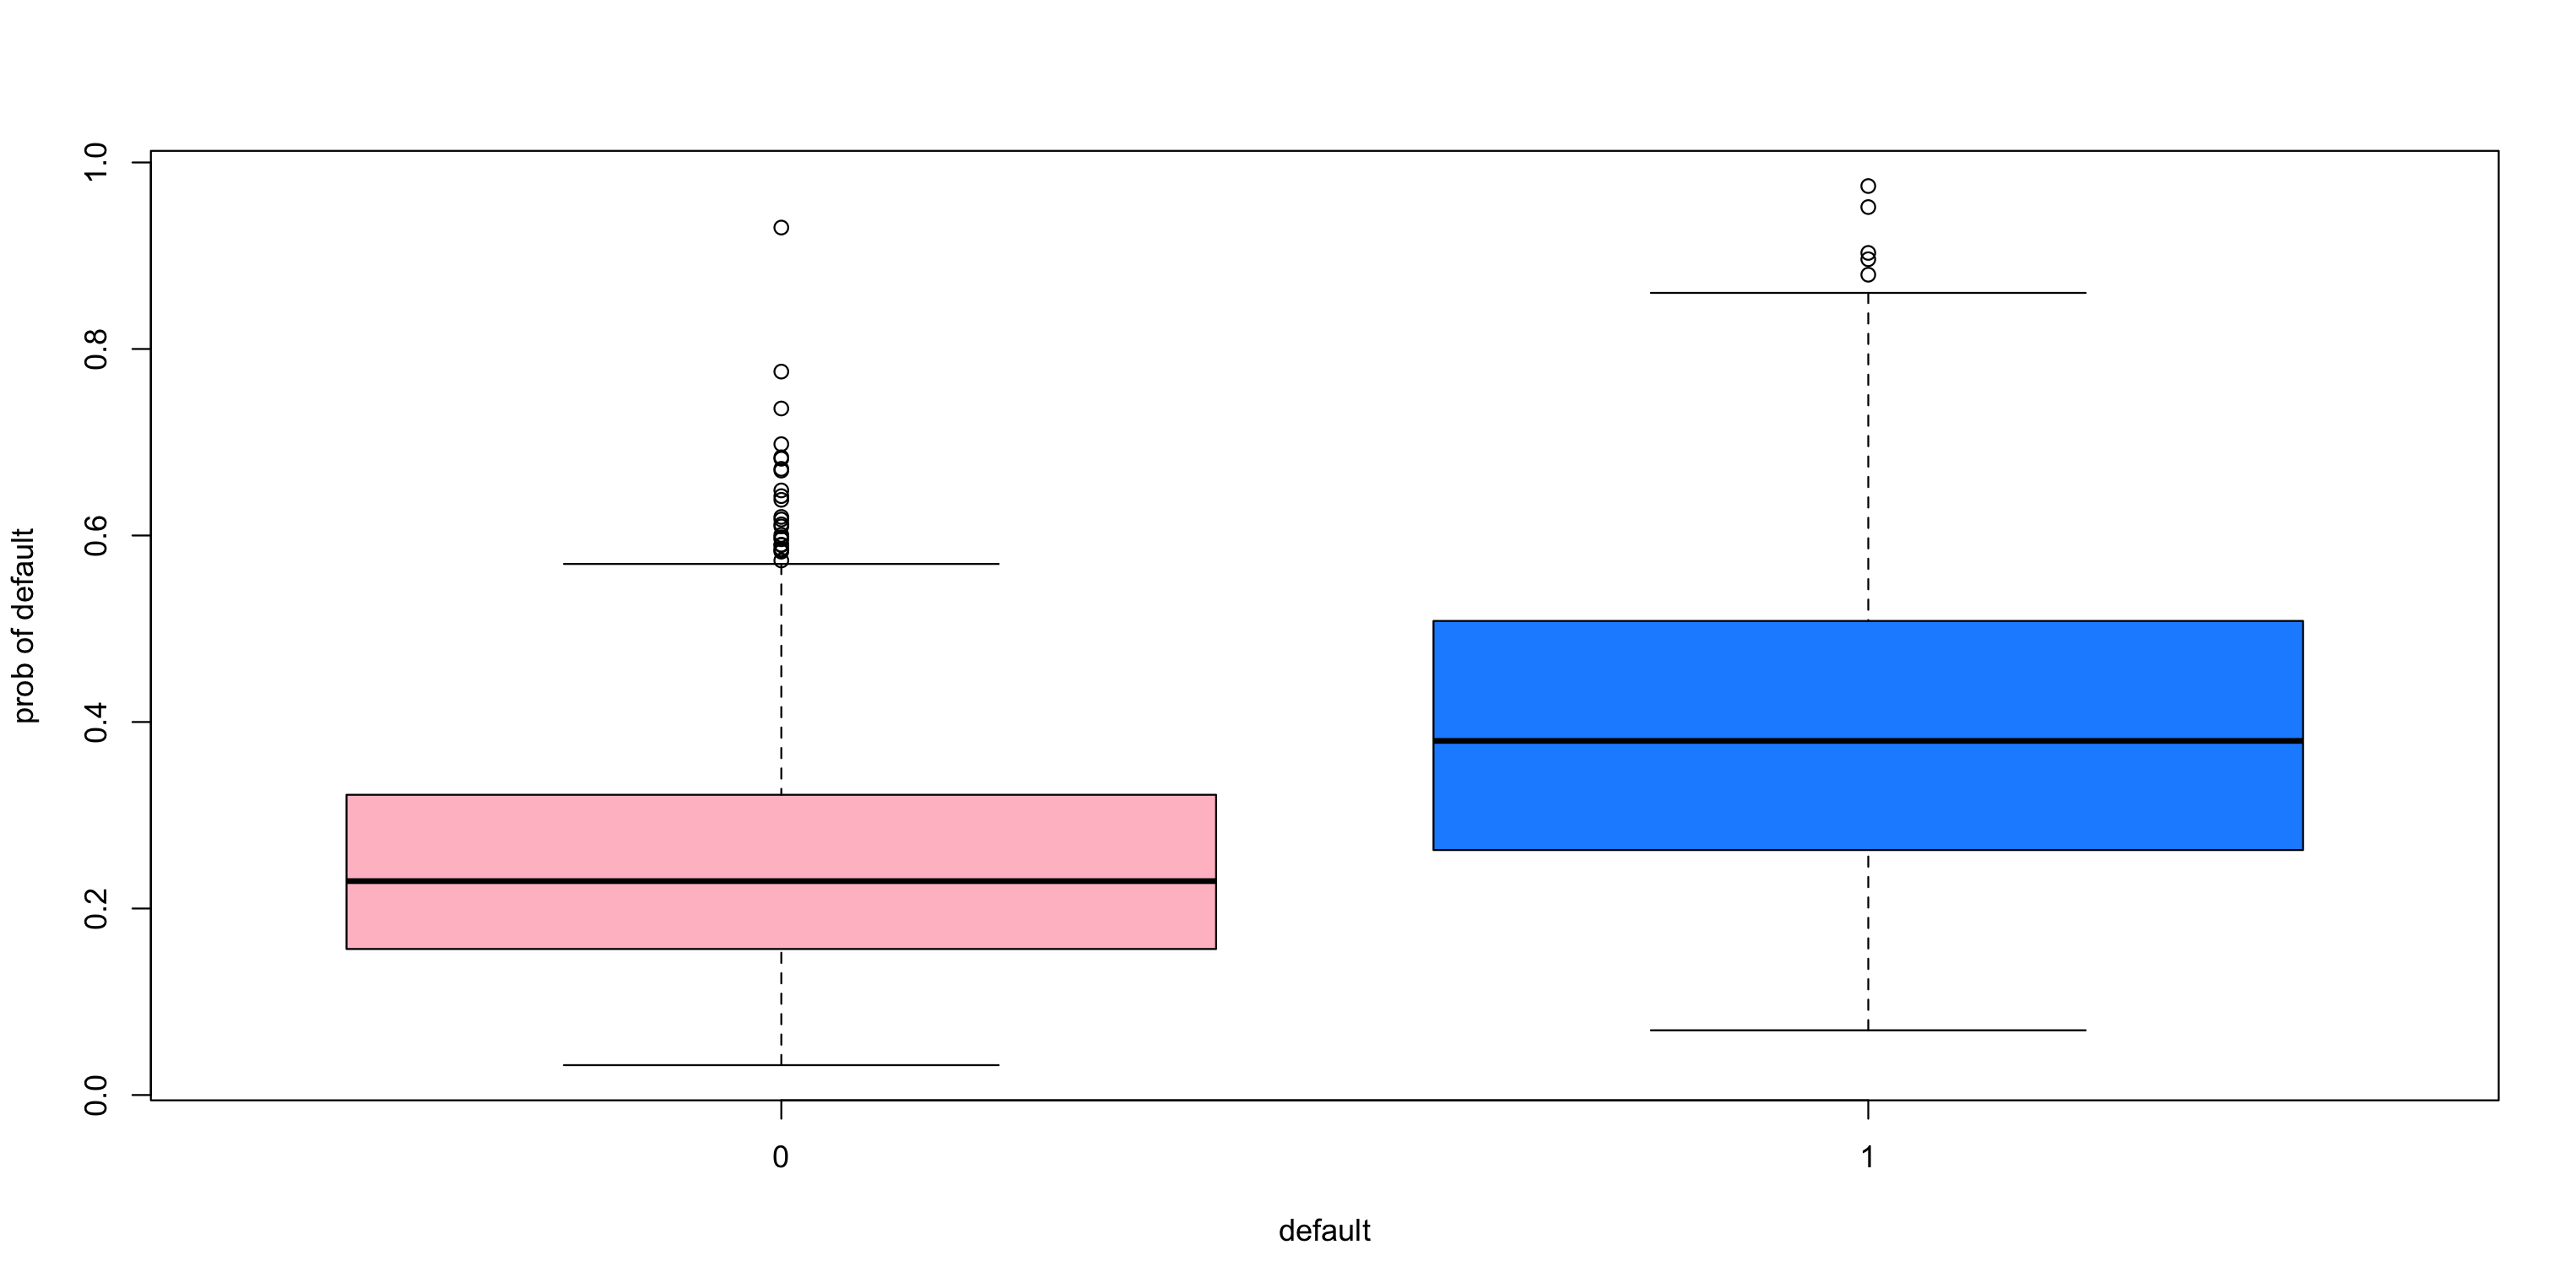

In [18]:
pred <- predict(credscore$gamlr, credx, type="response")
pred <- drop(pred) # remove the sparse Matrix formatting
boxplot(pred ~ default, xlab="default", ylab="prob of default", col=c("pink","dodgerblue"))

With this much overlap, expect misclassification error whichever probabilities you would use a rule.

See false positives and negatives with 0.2, say:

In [19]:
rule <- 1/5

sum( (pred>rule)[default==0] )/sum(pred>rule)
sum( (pred<rule)[default==1] )/sum(pred<rule)

[1] 0.6059744

[1] 0.07744108

These are slightly different from sensitivity and specificity, where the denominators come from the real data, not the predictions.

In [20]:
sum( (pred>rule)[default==1] )/sum(default==1) ## sensitivity
sum( (pred<rule)[default==0] )/sum(default==0) ## specificity

[1] 0.9233333

[1] 0.3914286

These can also be seen on an ROC curve, a weird name originating in radio days. More importantly, you can use this diagnostic in-sample and out-of-sample, just like R2. So let's reestimate the model on only half of the sample. Also make the predictions out of sample but also load the true data we happen to know even out of sample (just not use it for estimation).

In [21]:
test <- sample.int(1000,500)
credhalf <- gamlr(credx[-test,], default[-test], family="binomial")
predoos <- predict(credhalf, credx[test,], type="response")
defaultoos <- default[test]

We can use canned code for the ROC curve. You can also add points manually, e.g. ones corresponding to specific classification rules.

Here are the in-sample and the out-of-sample ones next to each other:

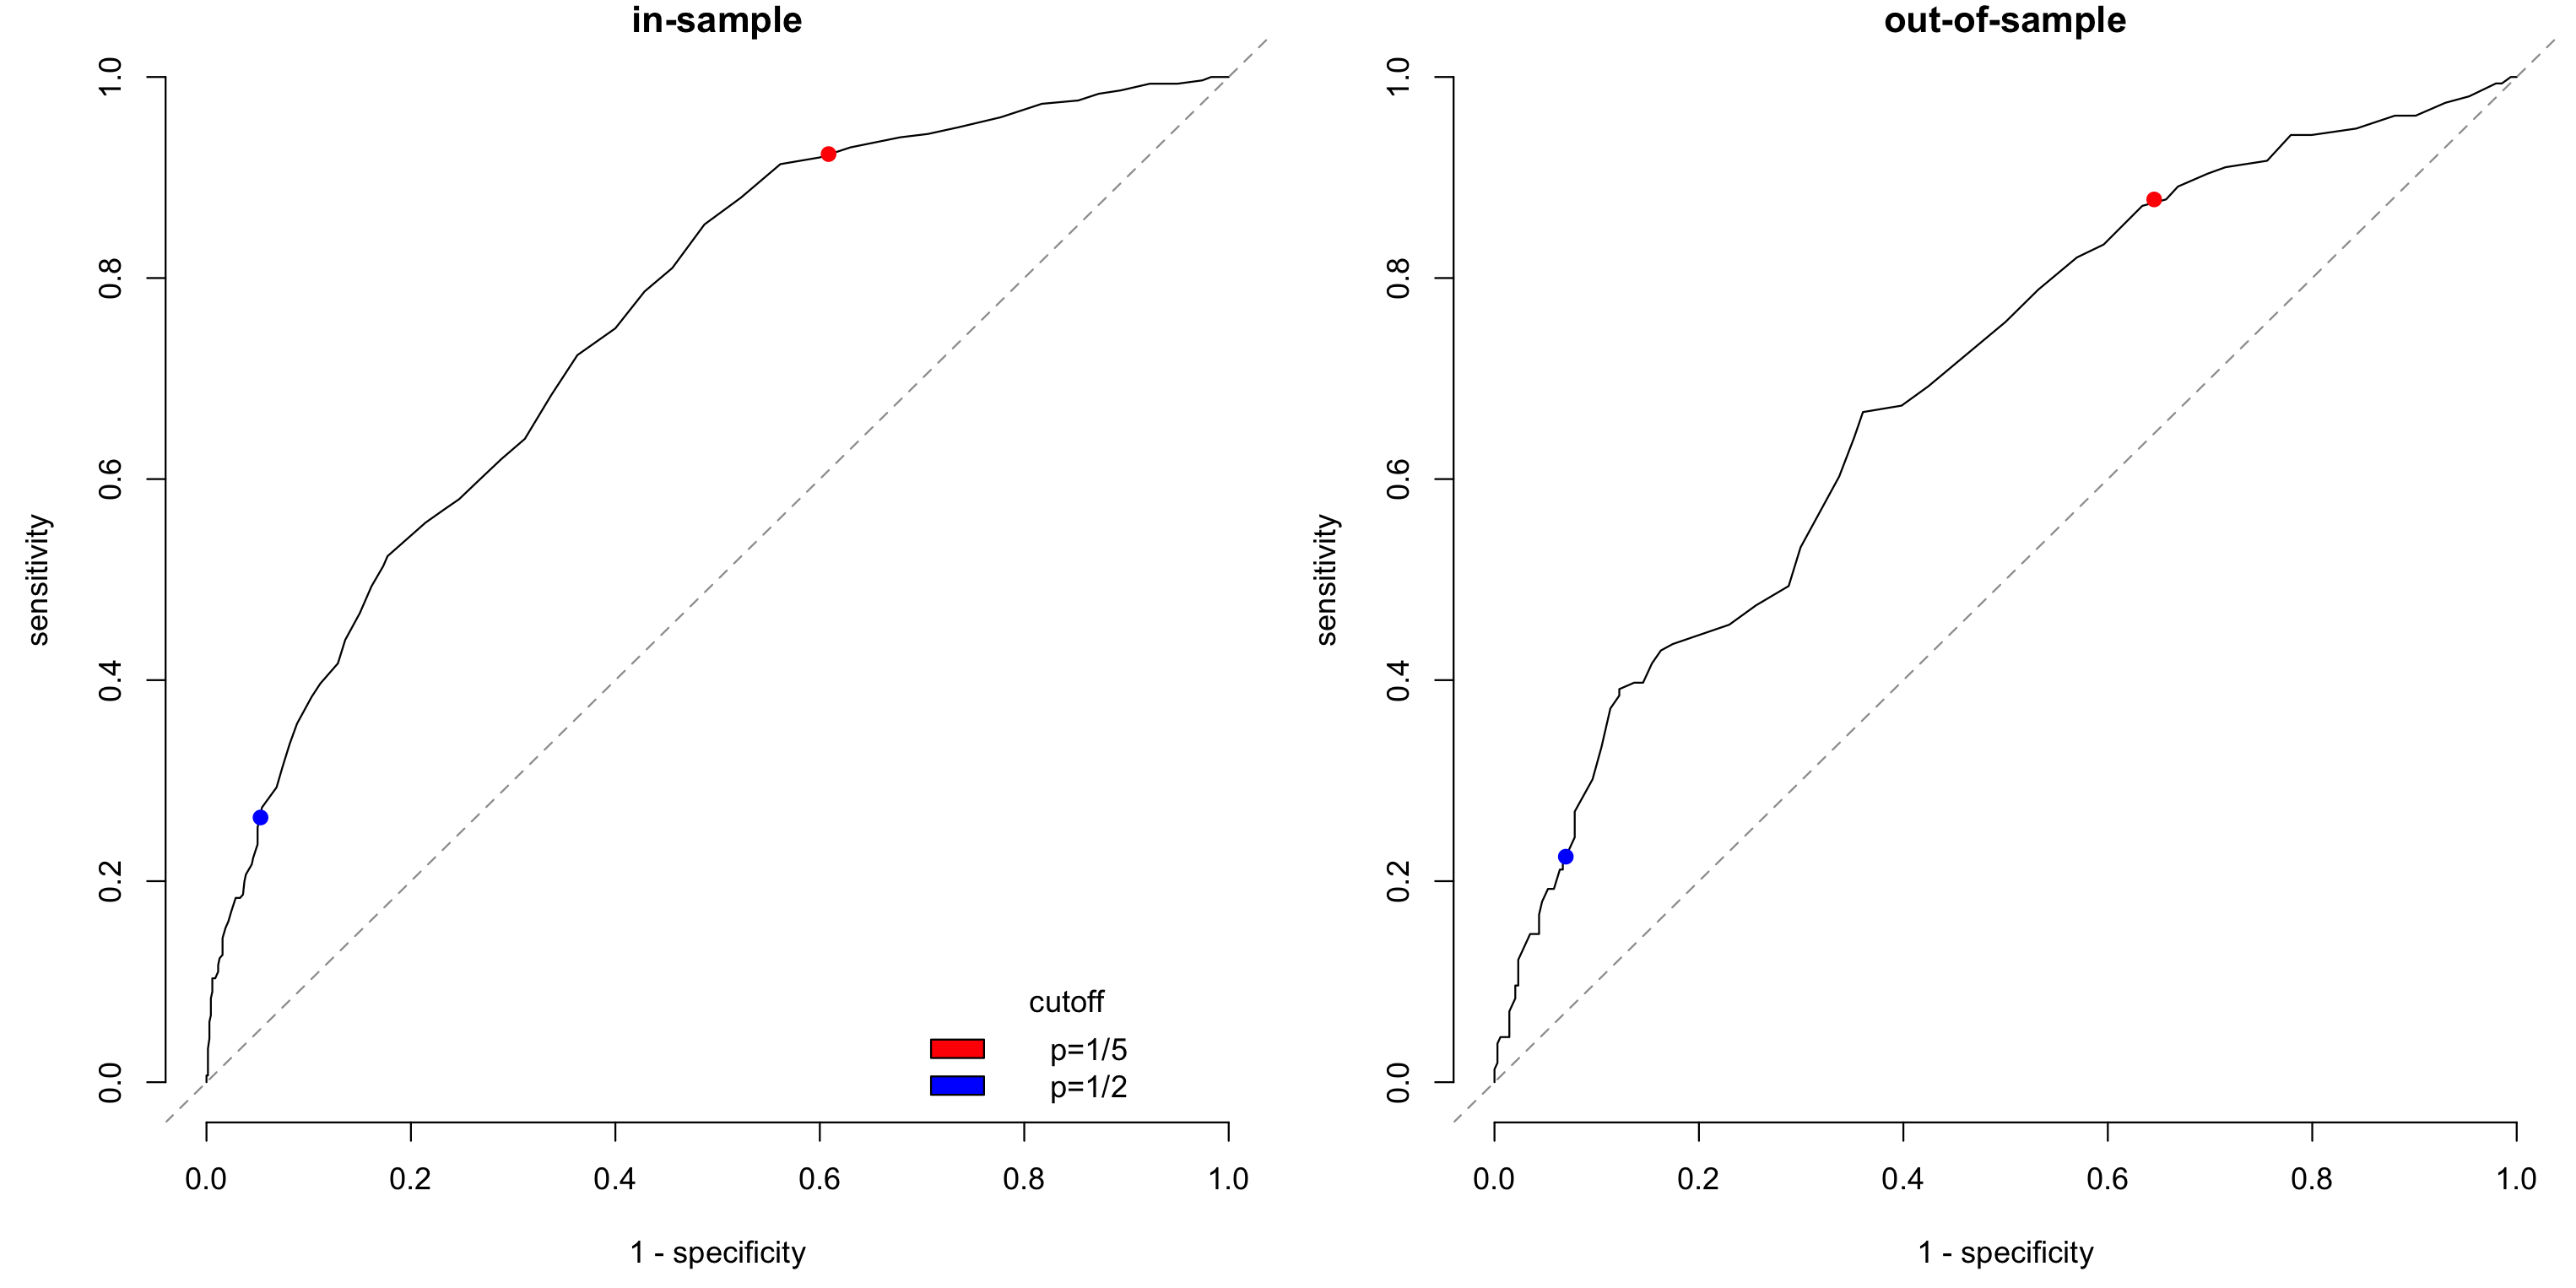

In [22]:
source("roc.R")

par(mai=c(.9,.9,.2,.1), mfrow=c(1,2))
roc(p=pred, y=default, bty="n", main="in-sample")
# our 1/5 rule cutoff
points(x= 1-mean((pred<.2)[default==0]), 
	y=mean((pred>.2)[default==1]), 
	cex=1.5, pch=20, col='red')
## a standard `max prob' (p=.5) rule
points(x= 1-mean((pred<.5)[default==0]), 
	y=mean((pred>.5)[default==1]), 
	cex=1.5, pch=20, col='blue') 
legend("bottomright",fill=c("red","blue"),
	legend=c("p=1/5","p=1/2"),bty="n",title="cutoff")
roc(p=predoos, y=defaultoos, bty="n", main="out-of-sample")
## our 1/5 rule cutoff
points(x= 1-mean((predoos<.2)[defaultoos==0]), 
	y=mean((predoos>.2)[defaultoos==1]), 
	cex=1.5, pch=20, col='red') 
## a standard `max prob' (p=.5) rule
points(x= 1-mean((predoos<.5)[defaultoos==0]), 
	y=mean((predoos>.5)[defaultoos==1]), 
	cex=1.5, pch=20, col='blue') 

# Multinomial Logistic Regression with Forensic Glass

We'll use the standard R package for this.

In [23]:
install.packages("glmnet")
library(glmnet)


The downloaded binary packages are in
	/var/folders/dk/2_0472cd7h35shgpvb9y6g6xp8980h/T//Rtmp809doE/downloaded_packages


Loaded glmnet 4.0-2



Now we'll consider all content variables and interact them with the refractive index (RI). This has a similar shorthand in R.
You could also look at all interactions; you'd get a different model but similar performance out-of-sample

In [24]:
xfgl <- sparse.model.matrix(type~.*RI, data=fgl)[,-1]
gtype <- fgl$type

The cross-validated estimation takes a familiar form, with a familiar error plot (but with the average number of non-zero coefficients across classes):

Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


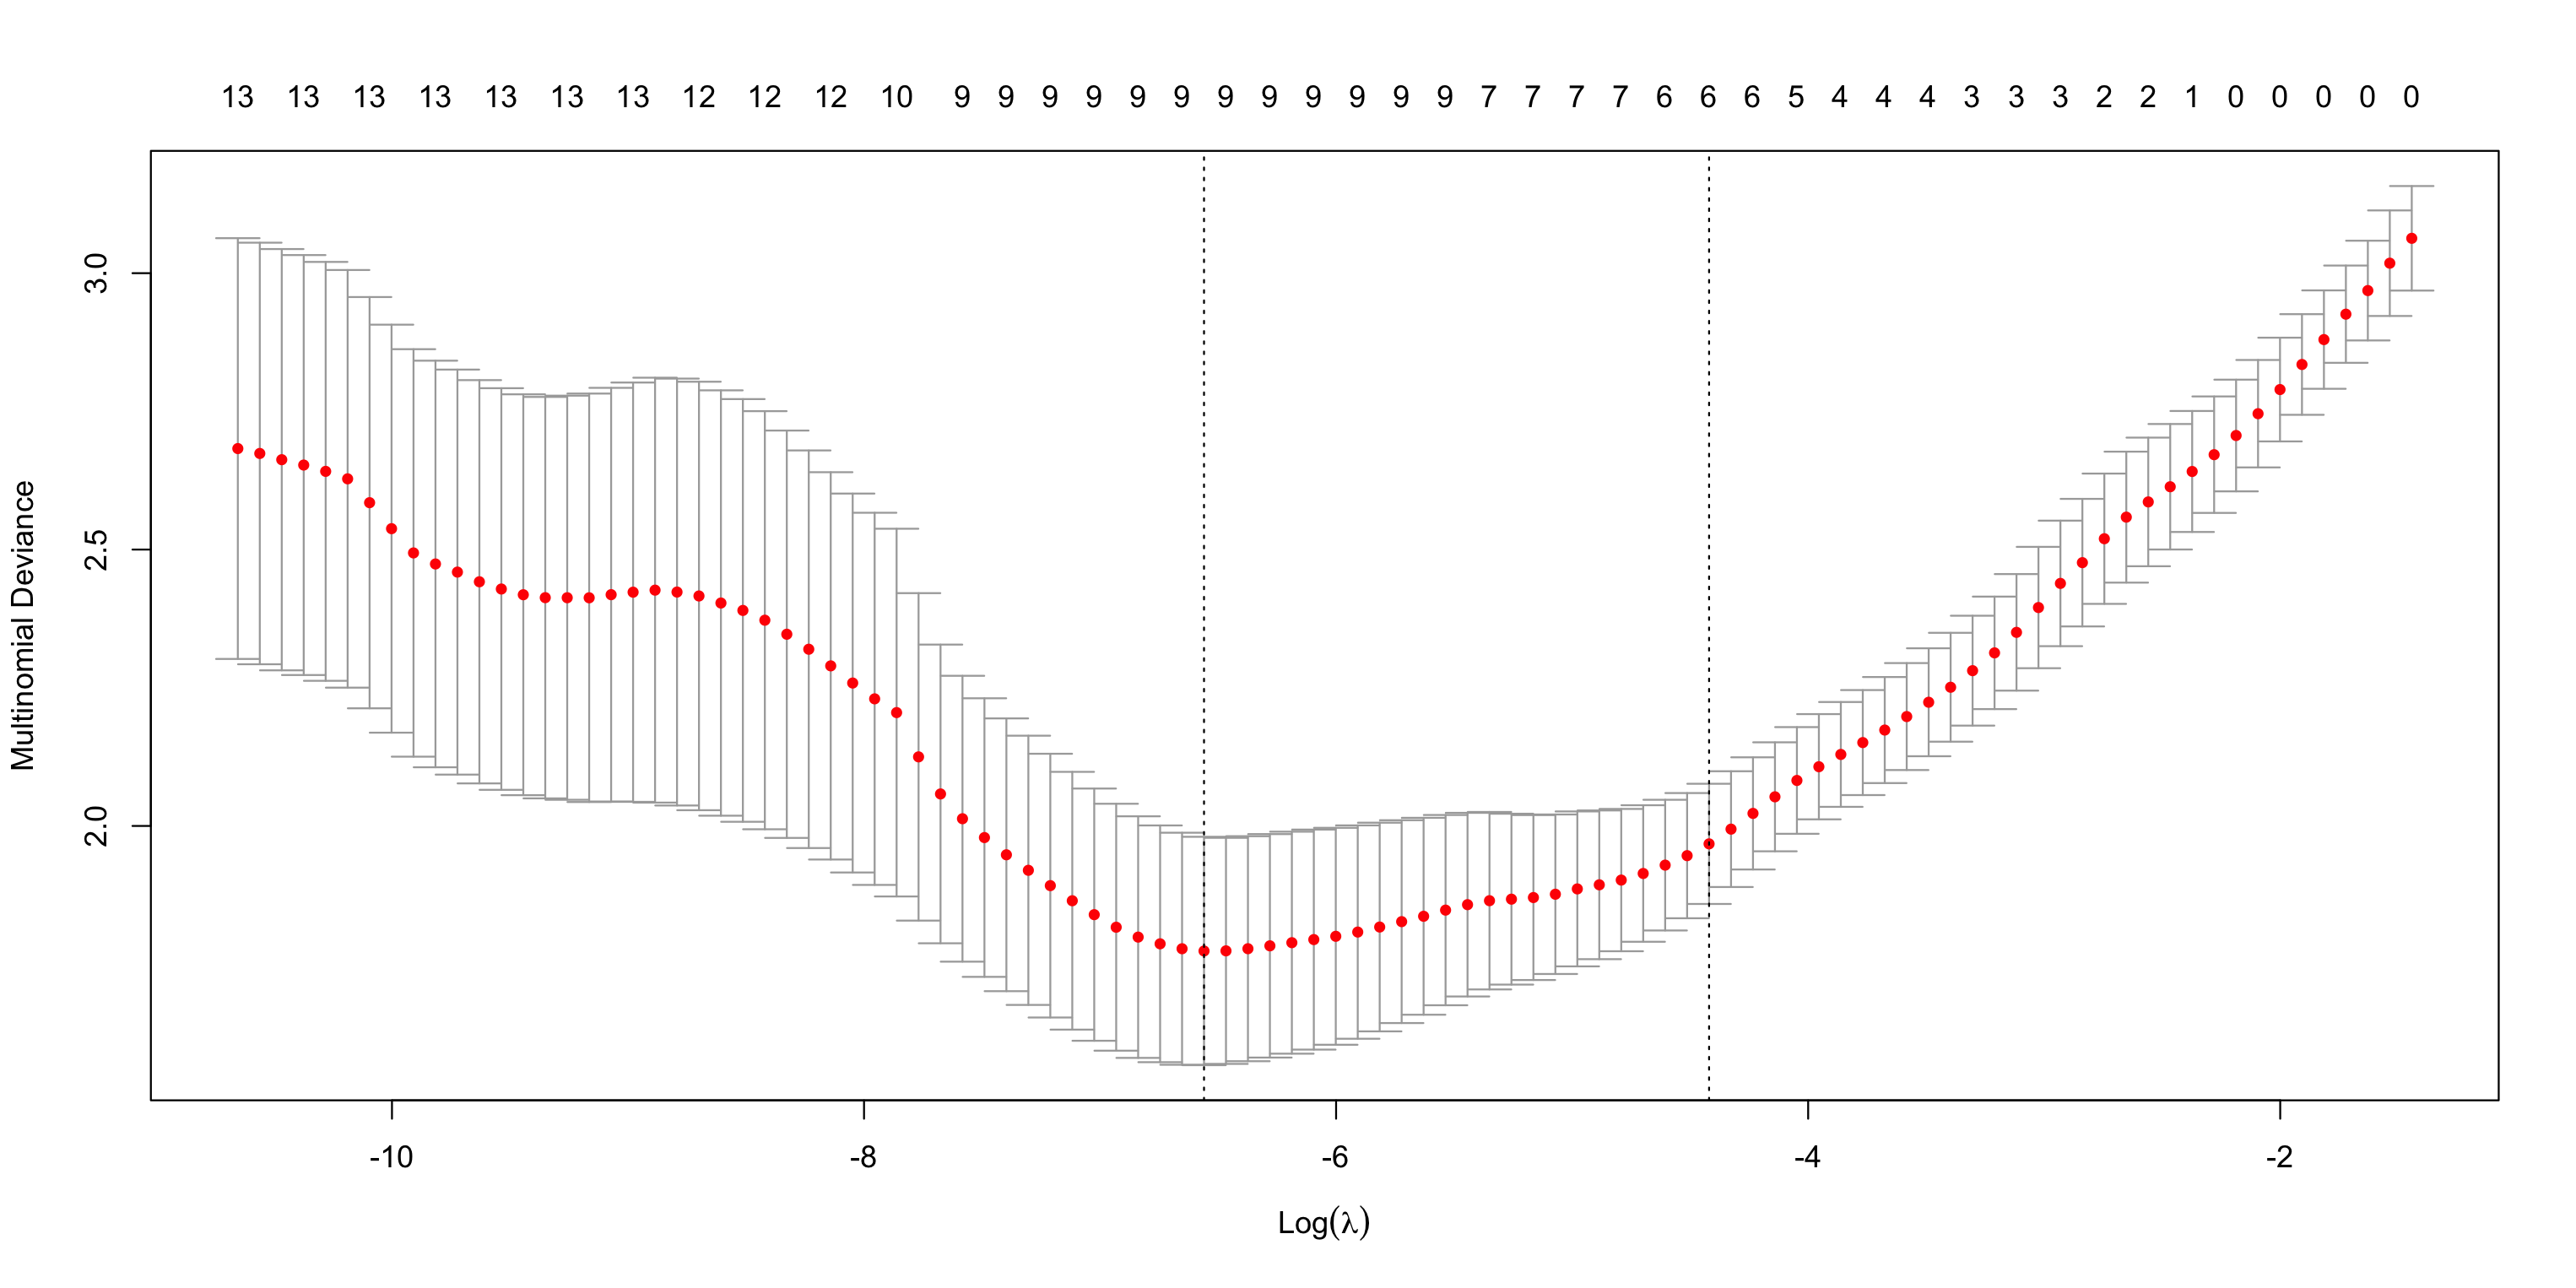

In [25]:
glassfit <- cv.glmnet(xfgl, gtype, family="multinomial")
plot(glassfit)

Our lasso regularization plot now plots the 6 sets of coefficient paths for each response class. (Note that `xvar="lambda"` actually plots against log lambda.)

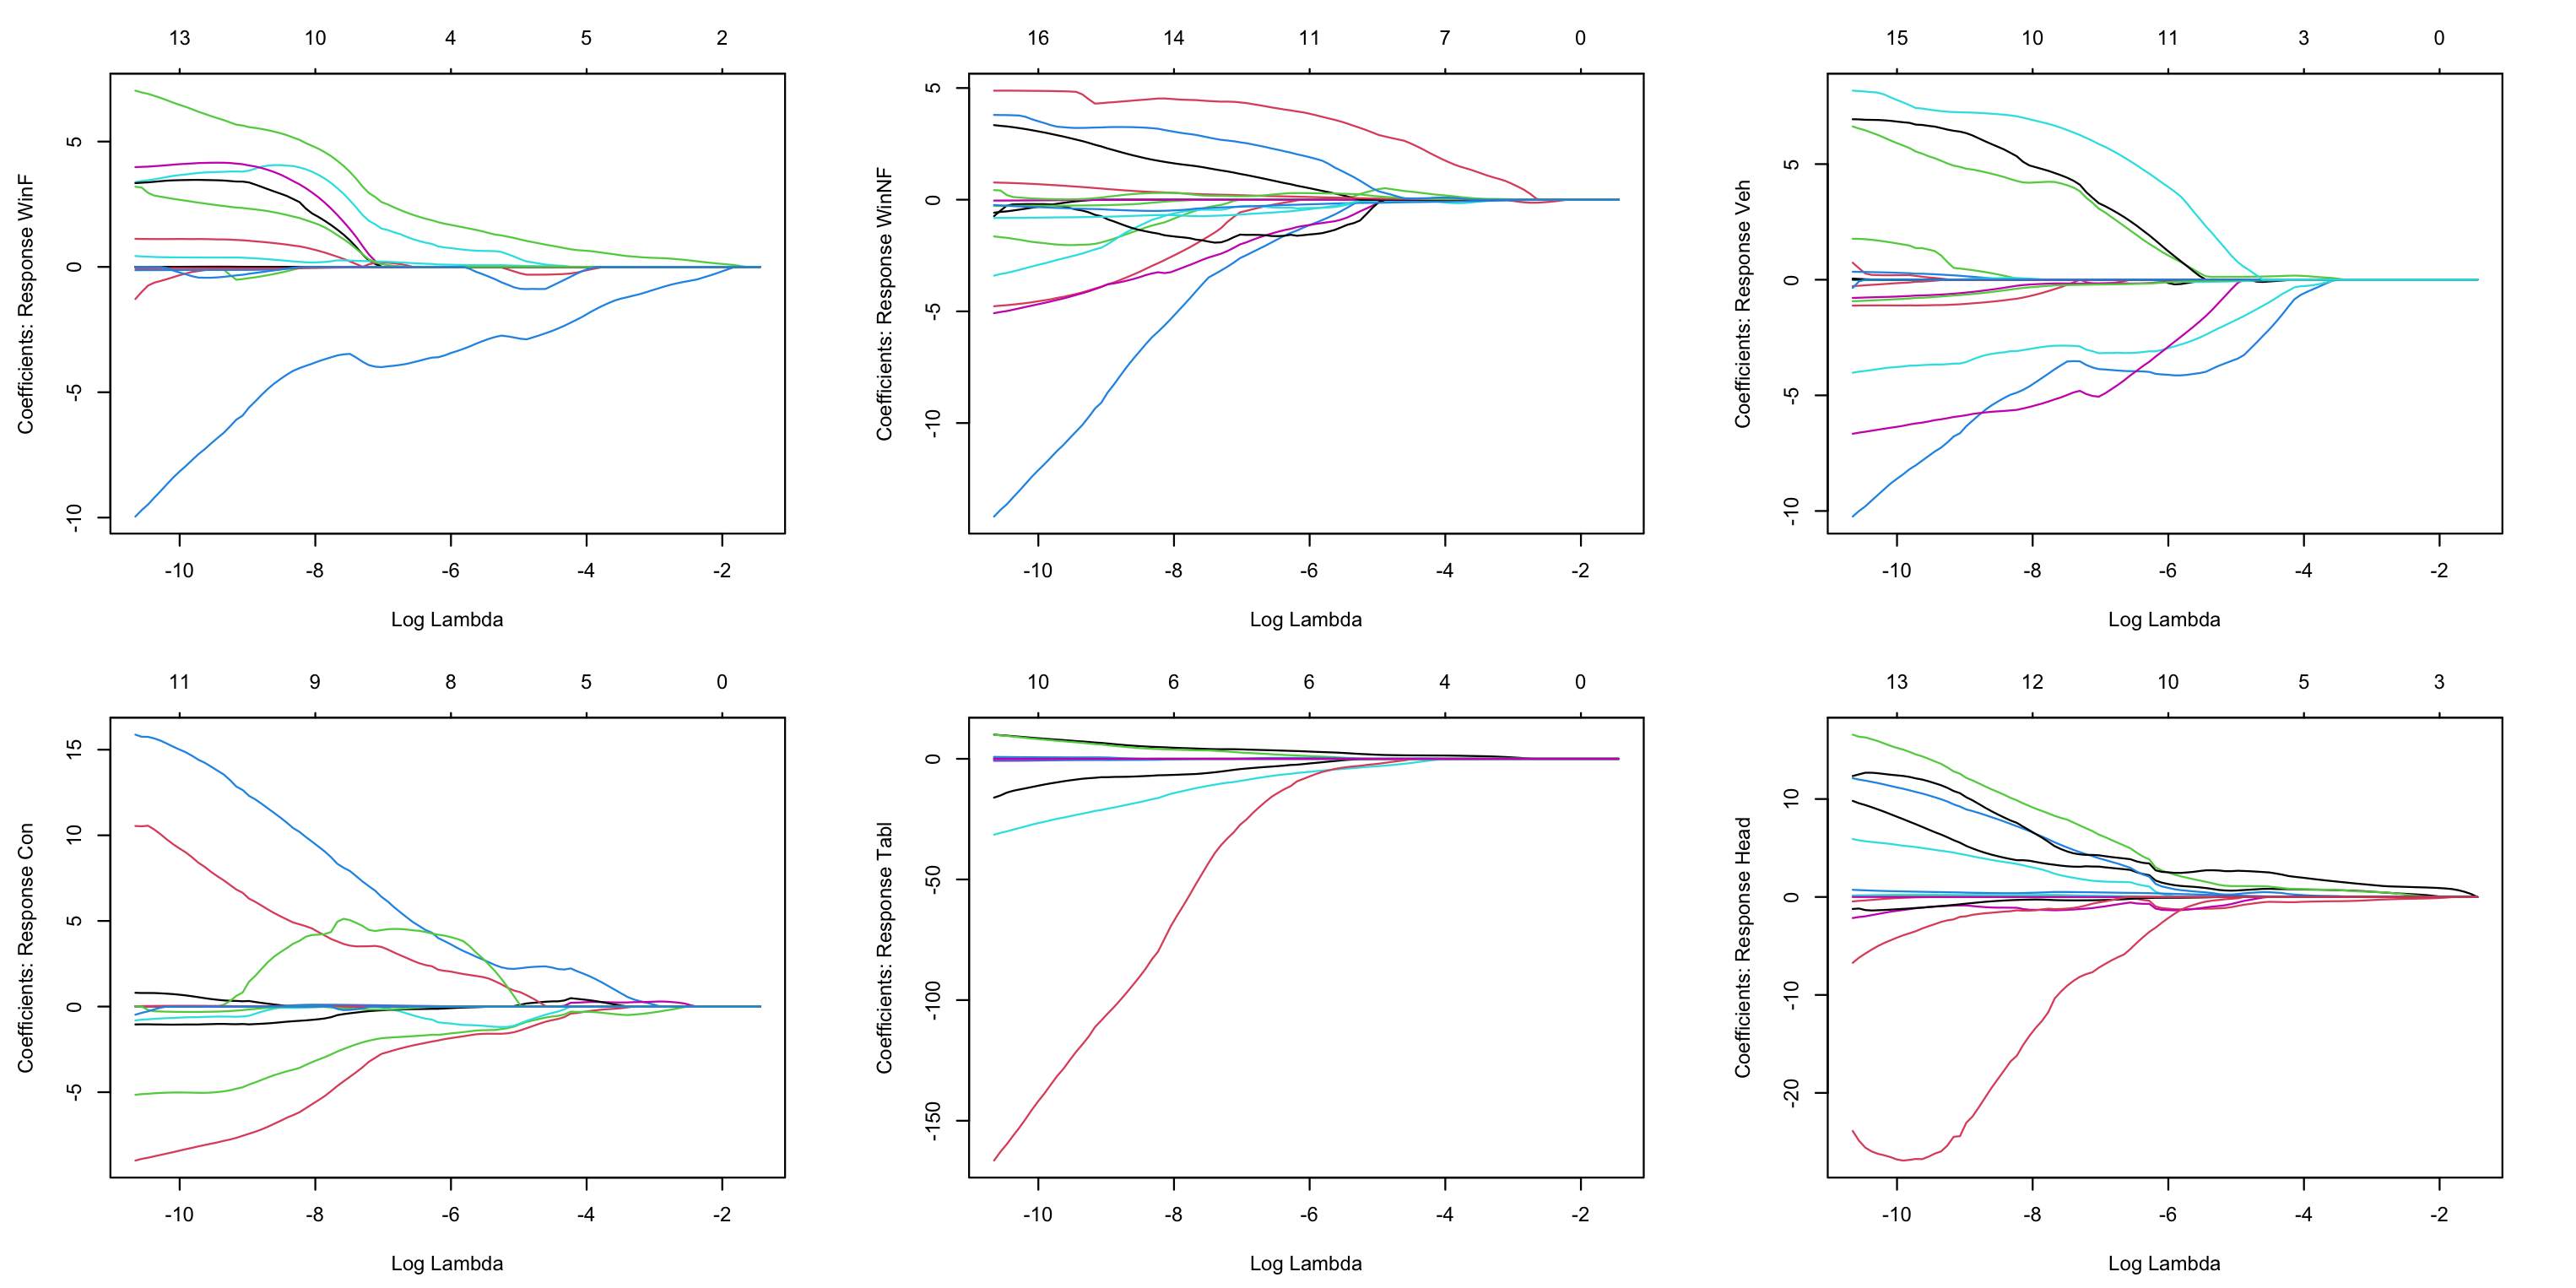

In [26]:
par(mfrow=c(2,3), mai=c(.6,.6,.4,.4))
plot(glassfit$glm, xvar="lambda") 

Once we extract coefficients, we'll got one set per glass type.

In [27]:
B  <- coef(glassfit, select="min")
B

$WinF
18 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) -1.23338990
RI           .         
Na          -0.29335083
Mg           0.79869147
Al          -2.45595509
Si           0.05366084
K            .         
Ca           .         
Ba           .         
Fe           .         
RI:Na        .         
RI:Mg        0.01445257
RI:Al        .         
RI:Si        .         
RI:K         .         
RI:Ca        .         
RI:Ba        .         
RI:Fe       -0.63614518

$WinNF
18 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.87237904
RI           .         
Na           .         
Mg           0.33016230
Al           .         
Si          -0.05366084
K            .         
Ca           .         
Ba           .         
Fe           2.39164677
RI:Na        .         
RI:Mg       -0.10722897
RI:Al        .         
RI:Si        .         
RI:K         .         
RI:Ca        0.02802109
RI:Ba        0.05296364
RI:Fe        0

We can combine them into a single matrix, but need to readd the column names.

In [28]:
B <- do.call(cbind, B)
colnames(B) <- levels(gtype)

We need fit plots to judge how well we did. Plot p_yi (probability) distribution for each true yi. `predict` will give us in-sample probabilities.

By some quirks of `glmnet`, predict gives you a higher dimensional array than the matrix we have in mind, so we need to `drop` to get a matrix. (nxKx1 array -> nxK matrix)

In [29]:
probfgl <- predict(glassfit, xfgl, type="response")
probfgl <- drop(probfgl)

The probability of what actually happened is tricky to get (elegantly). We can use a matrix to index a matrix, and get back the [i,j] entry of `probfgl` for each row of index matrix, or here the probability of true class for each observation.

In [30]:
n <- nrow(xfgl)
trueclassprobs <- probfgl[cbind(1:n, gtype)]

Let's plot these, with variable width to have the box widths proportional to response proportion. This is our in-sample fit.

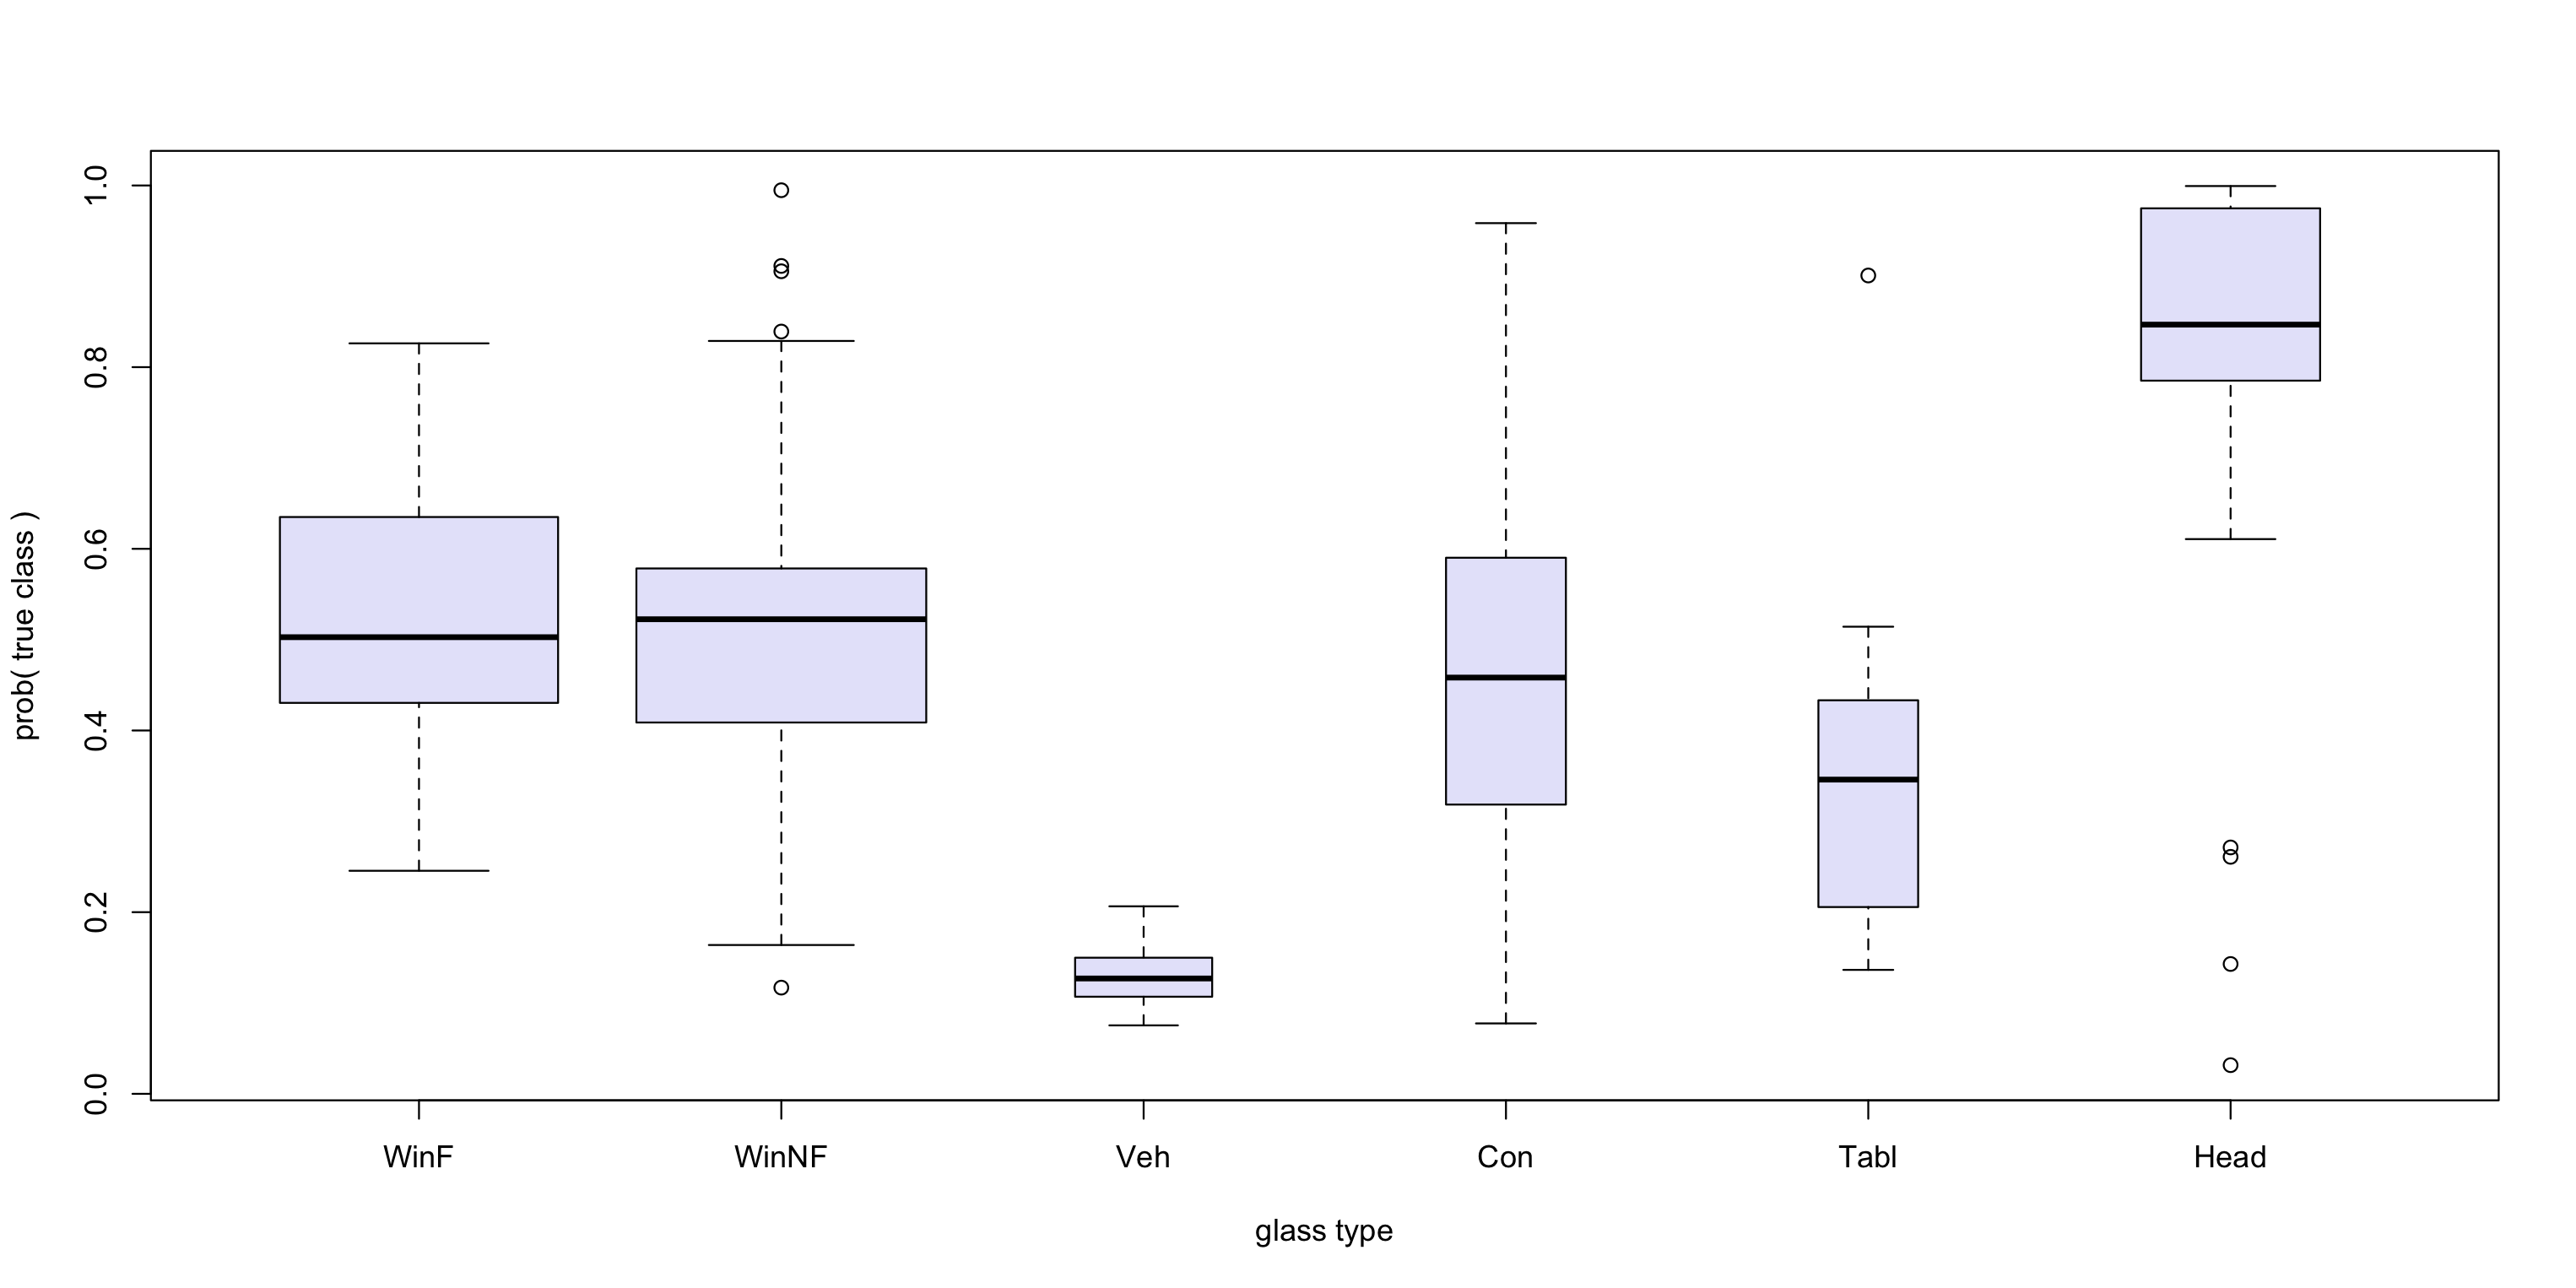

In [31]:
plot(trueclassprobs ~ gtype, col="lavender", varwidth=TRUE,
	xlab="glass type", ylab="prob( true class )") 

Let's do some classification that's not even in the book. Look at headlights vs all others (using a 0.9 rule)

In [32]:
headclass <- probfgl[,'Head'] > .9
sum(headclass)

[1] 11

We can also just do what we learnt for binary classifications whenever we are making one-vs-all-others type comparisons, for instance an ROC plot for headlamp glass vs other glass classification

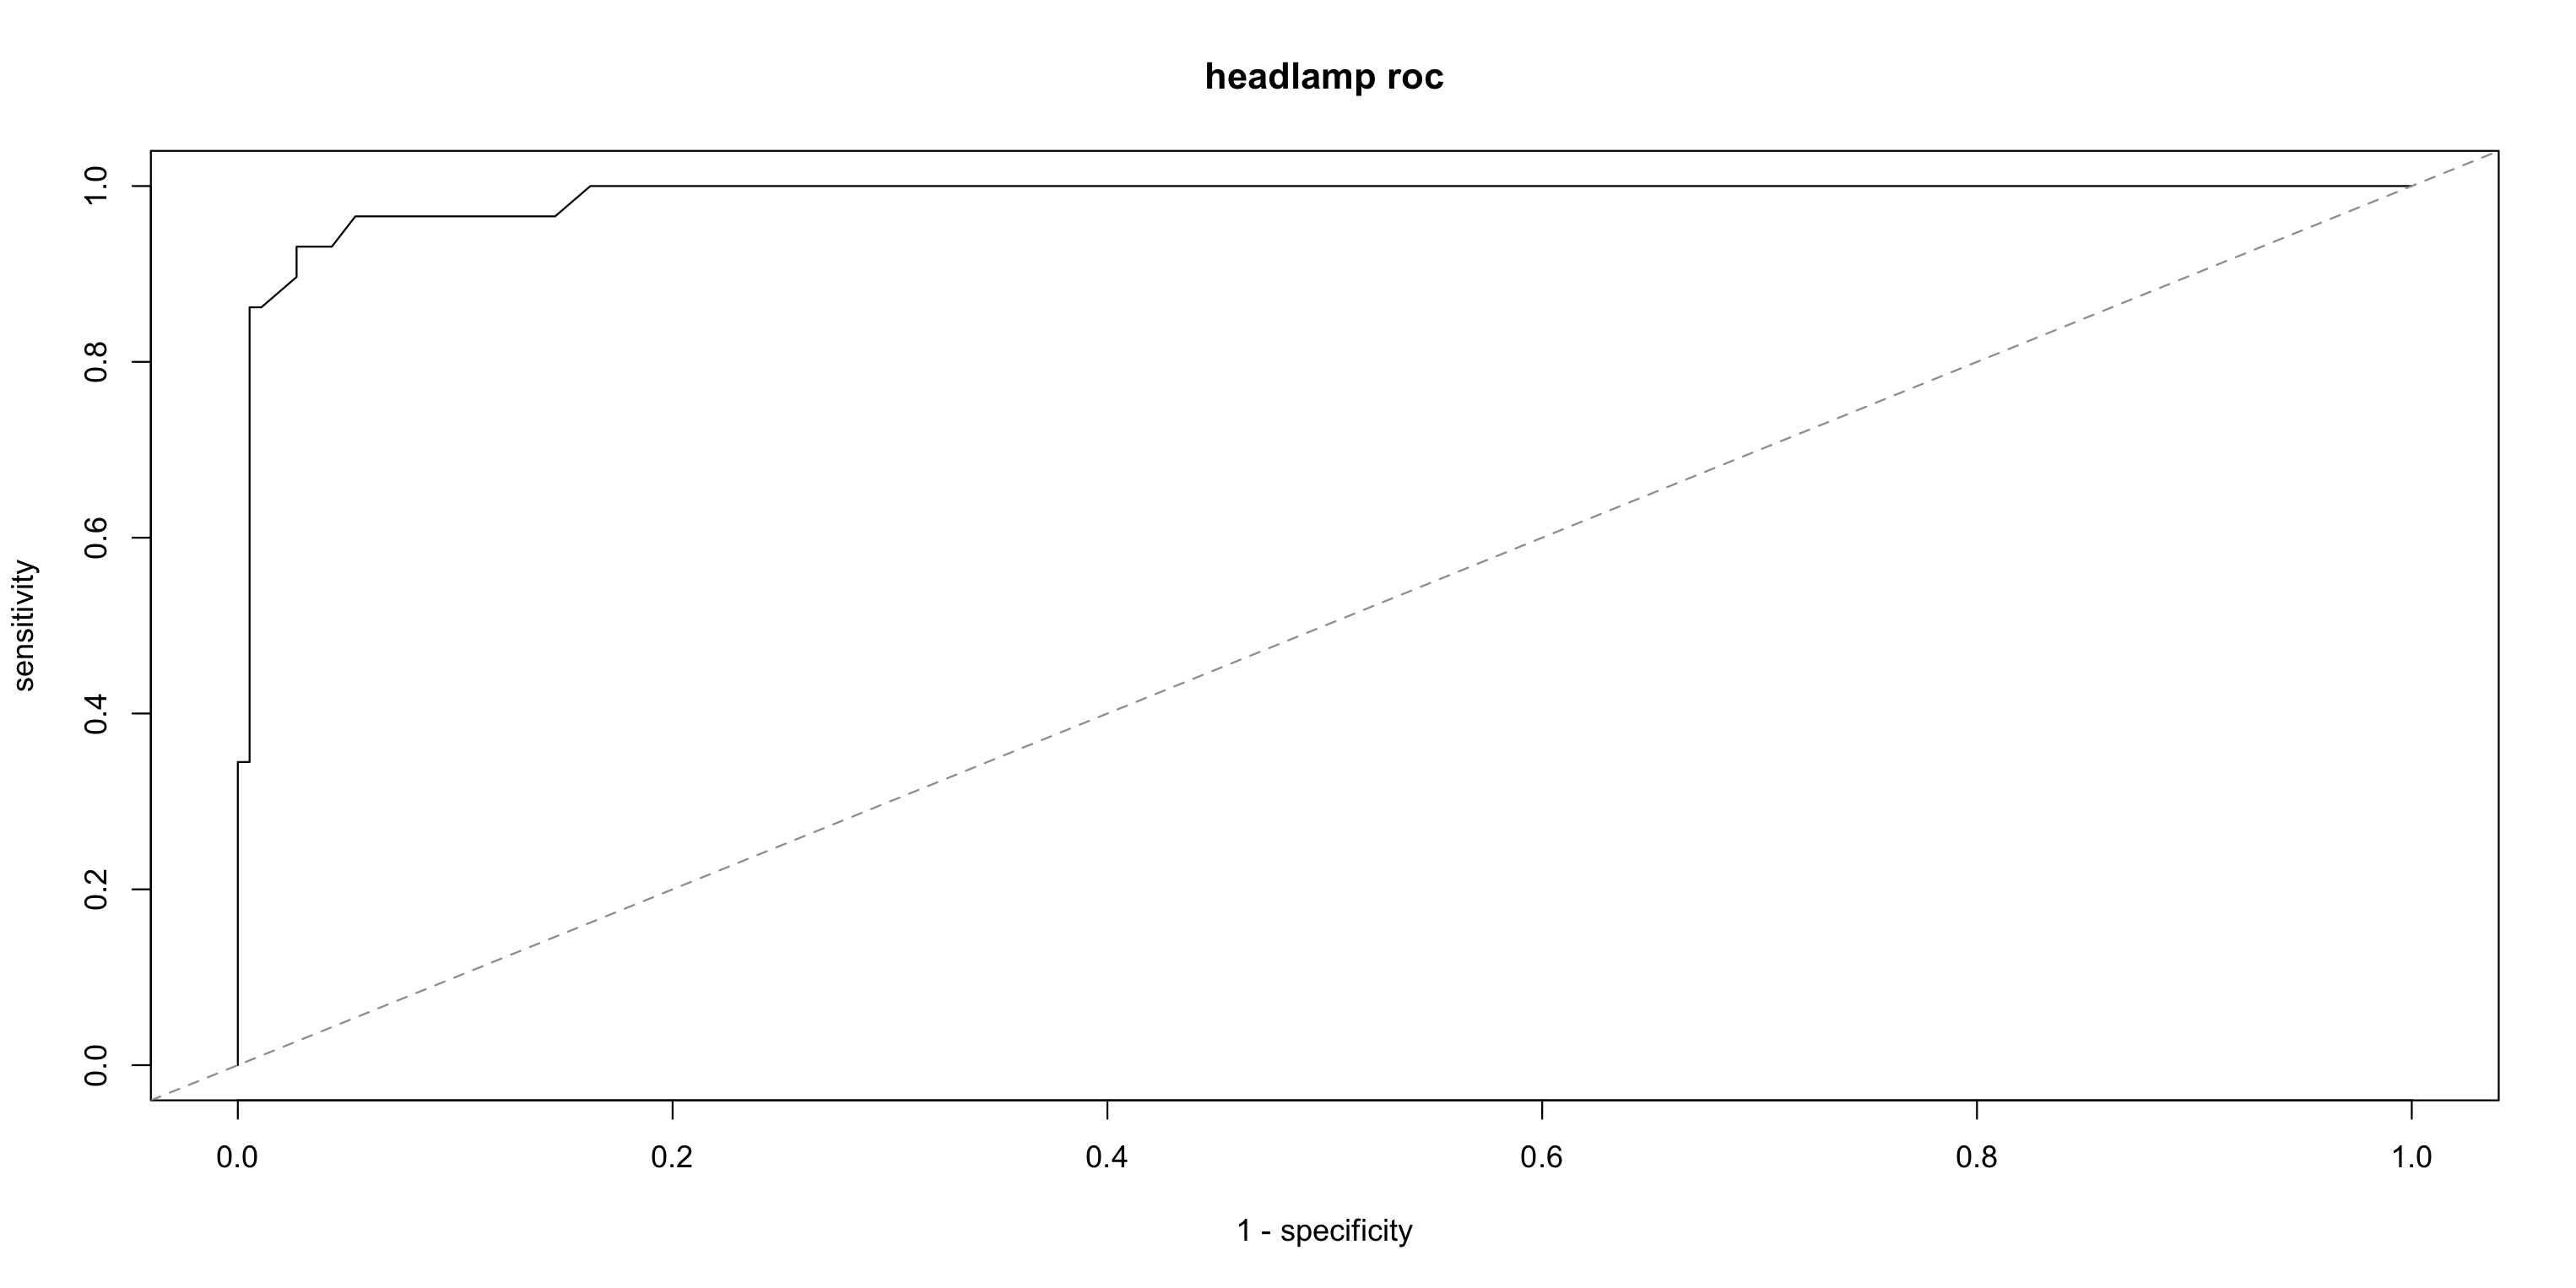

In [33]:
source("roc.R")
roc(p=probfgl[,'Head'], y=gtype=="Head", main="headlamp roc")

Or we can classify based on the maximal probability for each row (observation). We can
`apply` the `which.max` function for every row of probabilities.

In [34]:
class <- levels(gtype)[apply(probfgl,1,which.max)] 
cbind(class,as.character(gtype))

class,
WinF,WinF
WinNF,WinF
WinNF,WinF
WinF,WinF
WinF,WinF
WinNF,WinF
WinF,WinF
WinF,WinF
WinF,WinF
WinNF,WinF


## Interpretation examples

NOTE: due to CV variability we are not all guaranteed to get back the answers in the book.
It is more important to understand why the effect can move around with, say, RI. Just note the book does not spell out the interaction terms because it assumes to have set RI to zero…

In [35]:
RI <- 0

For an extra unit of Mg, we can spell out the change in the non-float vs float odds.(@RI=0 it should drop by  30-40%) 

In [36]:
exp( (B["Mg","WinNF"]+RI*B["RI:Mg","WinNF"]) -
			(B["Mg","WinF"]+RI*B["RI:Mg","WinF"]) )

[1] 0.6259222

The odds of non-float over Con should increase by 60-70%.

In [37]:
exp( (B["Mg","WinNF"]+RI*B["RI:Mg","WinNF"]) -
			(B["Mg","Con"]+RI*B["RI:Mg","Con"]) )

[1] 2.392818

Information criteria are more complicated for these models, if you checked glass.R…

##  Distributed multinomial regression

This uses Taddy's own package, but includes the `parallel` package the book also mentions.

In [38]:
#install.packages("distrom")
library(distrom)
detectCores()
cl = makeCluster(4)
cl

Loading required package: parallel



[1] 4

socket cluster with 4 nodes on host ‘localhost’

Let's see how `dmr` works.

In [39]:
glassdmr <- dmr(cl, xfgl, gtype, verb=TRUE)
names(glassdmr)
glassdmr[["WinF"]]

fitting 214 observations on 6 categories, 17 covariates.
converting counts matrix to column list...
distributed run.
socket cluster with 4 nodes on host ‘localhost’


[1] "WinF"  "WinNF" "Veh"   "Con"   "Tabl"  "Head"


poisson gamlr with 17 inputs and 100 segments.


It looks like we got back a list of `gamlr` objects. Maybe we can also plot their standard lasso paths?

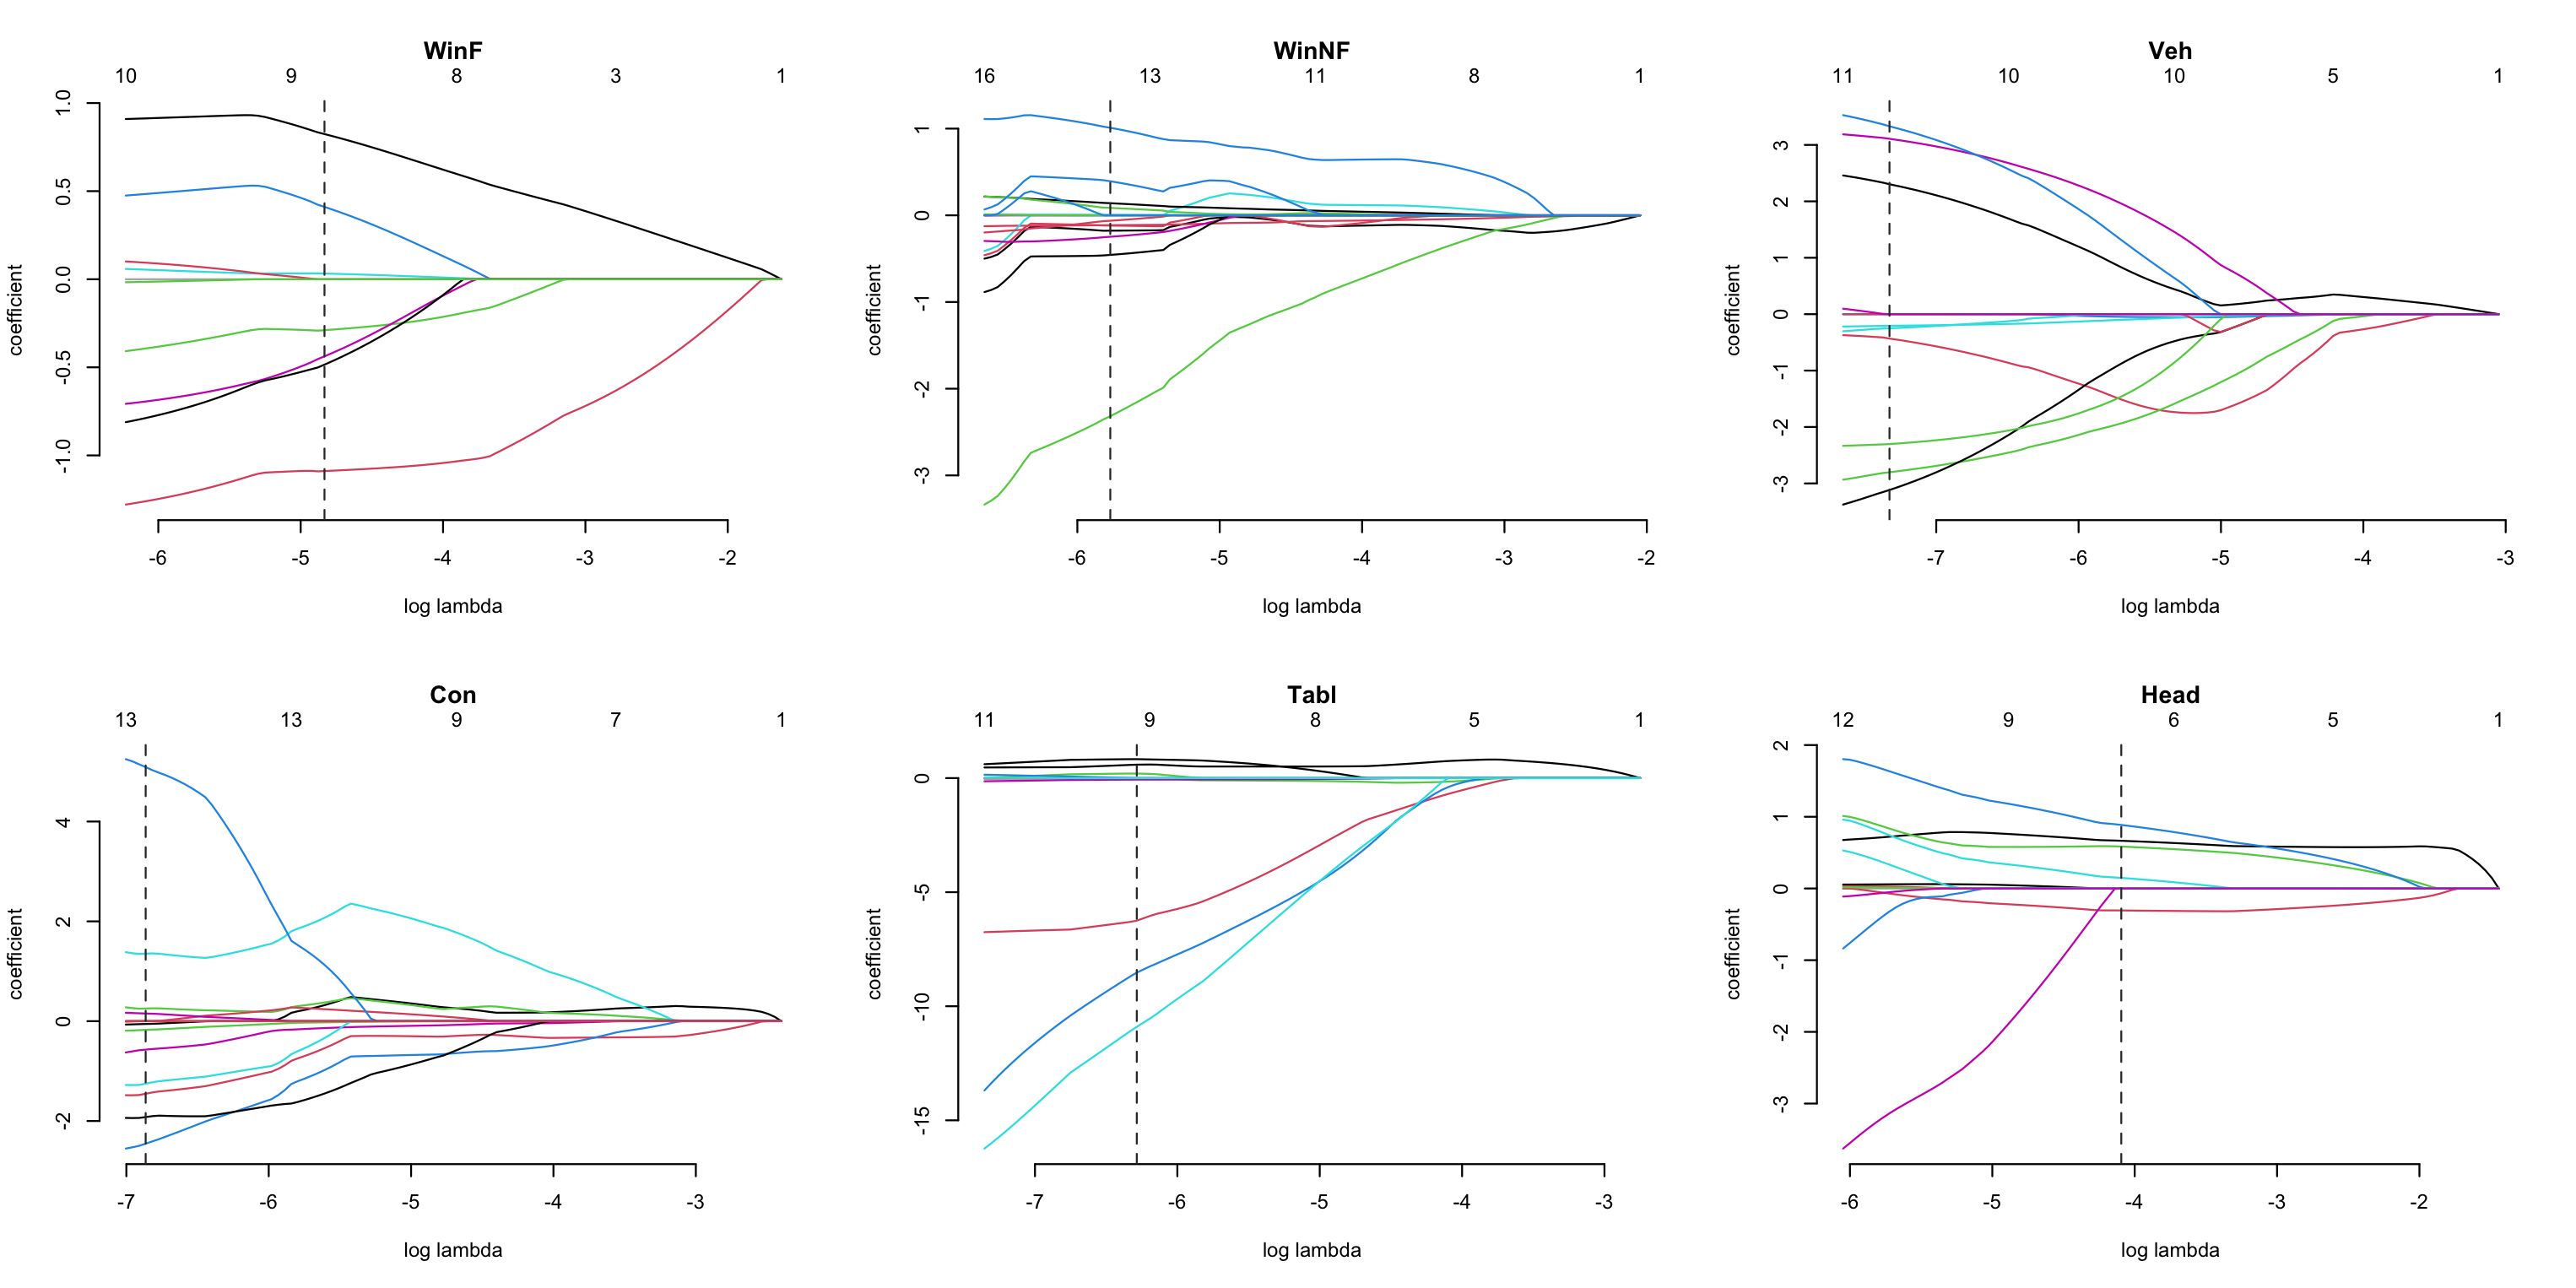

In [40]:
par(mfrow=c(2,3))
for(k in names(glassdmr)) plot(glassdmr[[k]], main=k)  

Or grab the AICc-selected coefficients?

In [41]:
Bdmr <- coef(glassdmr)

These look different from `glmnet`'s above. Mostly because `dmr` allowed a different lambda accross classes. Also, we used AICc rather than CV selection. Hopefully the predictions should be pretty close. It will be faster to call `predict` on the coefficient matrix rather than the raw object.

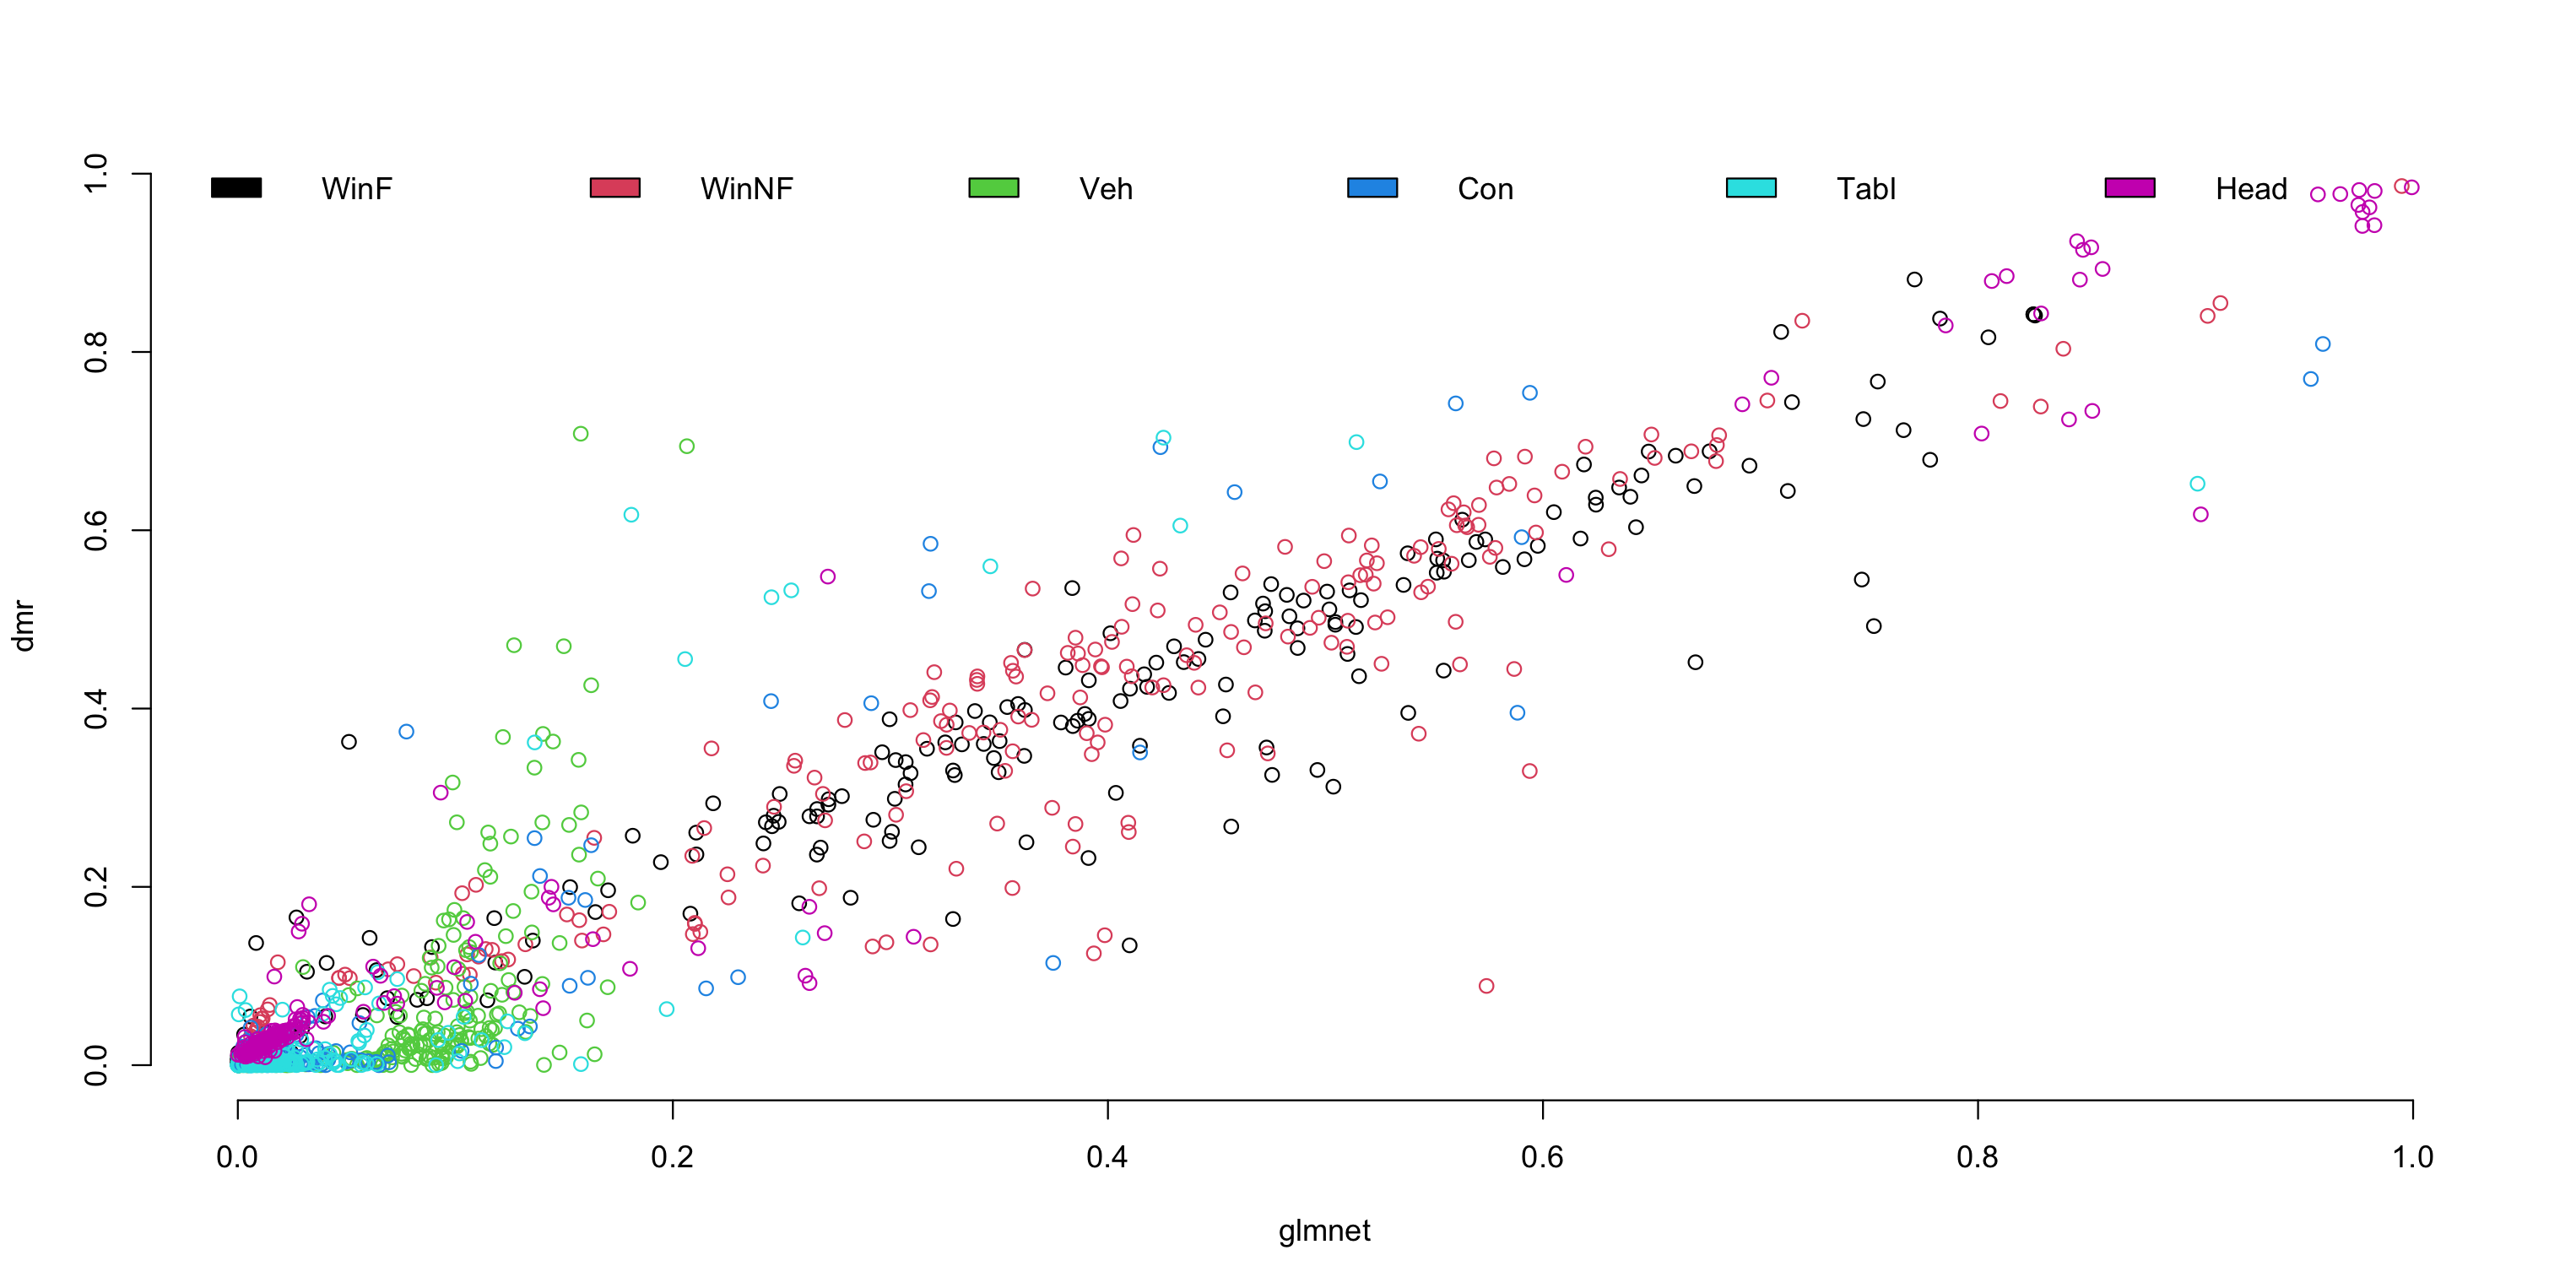

In [43]:
pdmr <- predict(Bdmr,xfgl,type="response")
plot(probfgl,pdmr,col=rep(1:6,each=n),xlab="glmnet",ylab="dmr",bty="n")
legend("topleft", fill=1:6, legend=levels(gtype), bty="n",h=TRUE)